In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
covid_data = pd.read_csv('US-Covid.csv')
covid_data.head()

,countyFIPS,County Name,State,StateFIPS,population,2020-06-01_cases,2020-06-02_cases,2020-06-03_cases,2020-06-04_cases,2020-06-05_cases,...,2020-12-25_deaths,2020-12-26_deaths,2020-12-27_deaths,2020-12-28_deaths,2020-12-29_deaths,2020-12-30_deaths,2020-12-31_deaths,2021-01-01_deaths,2021-01-02_deaths,2021-01-03_deaths
0,1001,Autauga County,AL,1,55869,233,238,239,241,248,...,46,46,47,47,47,48,48,50,50,50
1,1003,Baldwin County,AL,1,223234,292,292,292,293,296,...,151,151,152,152,156,160,161,169,169,169
2,1005,Barbour County,AL,1,24686,172,175,177,177,183,...,32,32,32,32,32,32,32,33,33,33
3,1007,Bibb County,AL,1,22394,76,76,76,76,76,...,42,42,42,42,42,46,46,46,46,46
4,1009,Blount County,AL,1,57826,63,63,63,63,64,...,58,58,58,58,58,63,63,63,63,63


In [71]:
enrichment_data = pd.read_csv('Economy.csv')
enrichment_data.head()

,Label (Grouping),California!!Estimate,California!!Percent
0,EMPLOYMENT STATUS,NaN,NaN
1,Population 16 years and over,"31,403,964","31,403,964"
2,In labor force,"20,016,955",63.7%
3,Civilian labor force,"19,875,973",63.3%
4,Employed,"18,646,894",59.4%


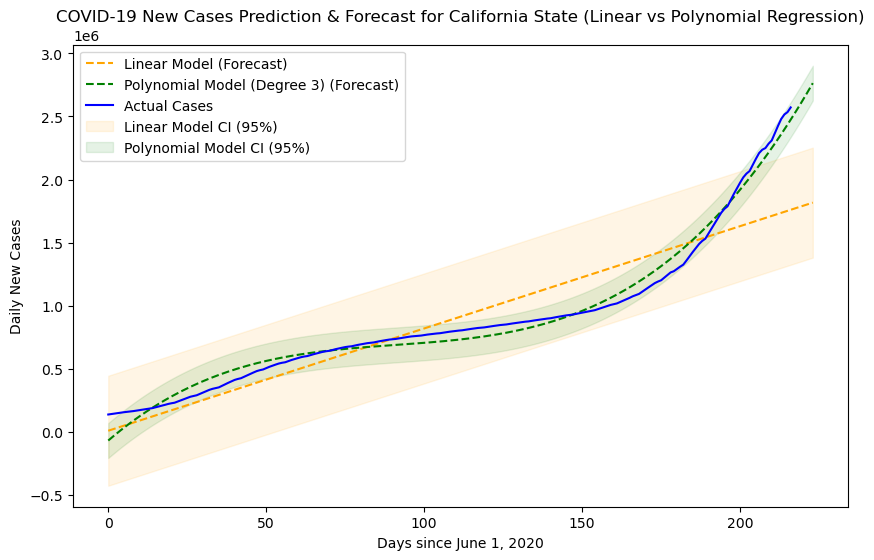

Linear RMSE (Cases): 222517.15
Polynomial RMSE (Cases): 70498.06


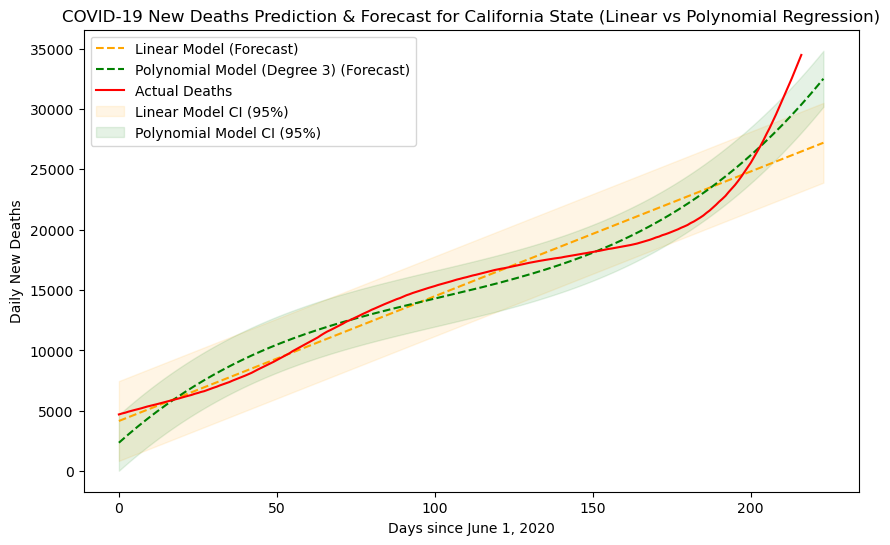

Linear RMSE (Deaths): 1685.45
Polynomial RMSE (Deaths): 1182.18 

Top 5 counties in California: 
                County Name  total_cases  total_deaths
204     Los Angeles County        858499         13000
221  San Bernardino County        220626          2939
218       Riverside County        205980          2550
222       San Diego County        181373          1881
215          Orange County        180621          2809


In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

df_united_states = pd.read_csv('US-Covid.csv')
df_california = df_united_states[df_united_states['State'] == 'CA'].copy()

case_columns = [col for col in df_california.columns if '_cases' in col]
death_columns = [col for col in df_california.columns if '_deaths' in col]

# Calculate the total cumulative number of cases and deaths for each county
df_california.loc[:, 'total_cases'] = df_california[case_columns].iloc[:, -1]
df_california.loc[:, 'total_deaths'] = df_california[death_columns].iloc[:, -1]

df_california.to_csv('df_california_with_total_cases_and_deaths.csv', index=False)

# --- Do the linear and polynomial RMSE for California ---

# Sum daily cases and deaths across all counties to get state-level data
state_cases = df_california[case_columns].sum()
state_deaths = df_california[death_columns].sum()

# Convert to numpy arrays for plotting and analysis
X = np.array(range(len(case_columns))).reshape(-1, 1)  # Days since start
y_cases = state_cases.values
y_deaths = state_deaths.values

# Linear Regression Model for Cases
linear_model_cases = LinearRegression()
linear_model_cases.fit(X, y_cases)
y_linear_pred_cases = linear_model_cases.predict(X)
linear_rmse_cases = np.sqrt(mean_squared_error(y_cases, y_linear_pred_cases))

# Polynomial Regression Model (degree 3) for Cases
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(X)
poly_model_cases = LinearRegression()
poly_model_cases.fit(X_poly, y_cases)
y_poly_pred_cases = poly_model_cases.predict(X_poly)
poly_rmse_cases = np.sqrt(mean_squared_error(y_cases, y_poly_pred_cases))

# Linear Regression Model for Deaths
linear_model_deaths = LinearRegression()
linear_model_deaths.fit(X, y_deaths)
y_linear_pred_deaths = linear_model_deaths.predict(X)
linear_rmse_deaths = np.sqrt(mean_squared_error(y_deaths, y_linear_pred_deaths))

# Polynomial Regression Model (degree 3) for Deaths
poly_model_deaths = LinearRegression()
poly_model_deaths.fit(X_poly, y_deaths)
y_poly_pred_deaths = poly_model_deaths.predict(X_poly)
poly_rmse_deaths = np.sqrt(mean_squared_error(y_deaths, y_poly_pred_deaths))

future_days = 7
X_future = np.array(range(len(case_columns) + future_days)).reshape(-1, 1)

# Predict future cases using the linear model
y_linear_future_cases = linear_model_cases.predict(X_future)

# Predict future cases using the polynomial model
X_future_poly = poly_features.fit_transform(X_future)
y_poly_future_cases = poly_model_cases.predict(X_future_poly)

# Plotting the forecast results for Cases
plt.figure(figsize=(10, 6))
plt.plot(X_future, y_linear_future_cases, color='orange', linestyle='--', label='Linear Model (Forecast)')
plt.plot(X_future, y_poly_future_cases, color='green', linestyle='--', label='Polynomial Model (Degree 3) (Forecast)')
plt.plot(X, y_cases, color='blue', label='Actual Cases')

# Calculate confidence interval for linear model (95% confidence)
y_linear_std_error = np.std(y_cases - y_linear_pred_cases)
ci = 1.96 * y_linear_std_error  # 95% confidence interval
plt.fill_between(X_future.flatten(), (y_linear_future_cases - ci), (y_linear_future_cases + ci), color='orange', alpha=0.1, label='Linear Model CI (95%)')

# Calculate confidence interval for polynomial model (95% confidence)
y_poly_std_error = np.std(y_cases - y_poly_pred_cases)
ci_poly = 1.96 * y_poly_std_error  # 95% confidence interval
plt.fill_between(X_future.flatten(), (y_poly_future_cases - ci_poly), (y_poly_future_cases + ci_poly), color='green', alpha=0.1, label='Polynomial Model CI (95%)')

plt.xlabel('Days since June 1, 2020')
plt.ylabel('Daily New Cases')
plt.title('COVID-19 New Cases Prediction & Forecast for California State (Linear vs Polynomial Regression)')
plt.legend()
plt.show()

print(f'Linear RMSE (Cases): {linear_rmse_cases:.2f}')
print(f'Polynomial RMSE (Cases): {poly_rmse_cases:.2f}')

# Predict future deaths using the linear model
y_linear_future_deaths = linear_model_deaths.predict(X_future)

# Predict future deaths using the polynomial model
y_poly_future_deaths = poly_model_deaths.predict(X_future_poly)

# Plotting the forecast results for Deaths
plt.figure(figsize=(10, 6))
plt.plot(X_future, y_linear_future_deaths, color='orange', linestyle='--', label='Linear Model (Forecast)')
plt.plot(X_future, y_poly_future_deaths, color='green', linestyle='--', label='Polynomial Model (Degree 3) (Forecast)')
plt.plot(X, y_deaths, color='red', label='Actual Deaths')

# Calculate confidence interval for linear model (95% confidence)
y_linear_std_error_deaths = np.std(y_deaths - y_linear_pred_deaths)
ci_deaths = 1.96 * y_linear_std_error_deaths  # 95% confidence interval
plt.fill_between(X_future.flatten(), (y_linear_future_deaths - ci_deaths), (y_linear_future_deaths + ci_deaths), color='orange', alpha=0.1, label='Linear Model CI (95%)')

# Calculate confidence interval for polynomial model (95% confidence)
y_poly_std_error_deaths = np.std(y_deaths - y_poly_pred_deaths)
ci_poly_deaths = 1.96 * y_poly_std_error_deaths  # 95% confidence interval
plt.fill_between(X_future.flatten(), (y_poly_future_deaths - ci_poly_deaths), (y_poly_future_deaths + ci_poly_deaths), color='green', alpha=0.1, label='Polynomial Model CI (95%)')

plt.xlabel('Days since June 1, 2020')
plt.ylabel('Daily New Deaths')
plt.title('COVID-19 New Deaths Prediction & Forecast for California State (Linear vs Polynomial Regression)')
plt.legend()
plt.show()

print(f'Linear RMSE (Deaths): {linear_rmse_deaths:.2f}')
print(f'Polynomial RMSE (Deaths): {poly_rmse_deaths:.2f} \n')

# --- Continue with the rest ---

# Sort the DataFrame by total cases in descending order and select the top 5 counties
top_5_counties = df_california.sort_values(by='total_cases', ascending=False).head(5)

# Show California's top 5 counties (i.e. highest number of cases)
print("Top 5 counties in California: ")
print(top_5_counties[['County Name', 'total_cases', 'total_deaths']])

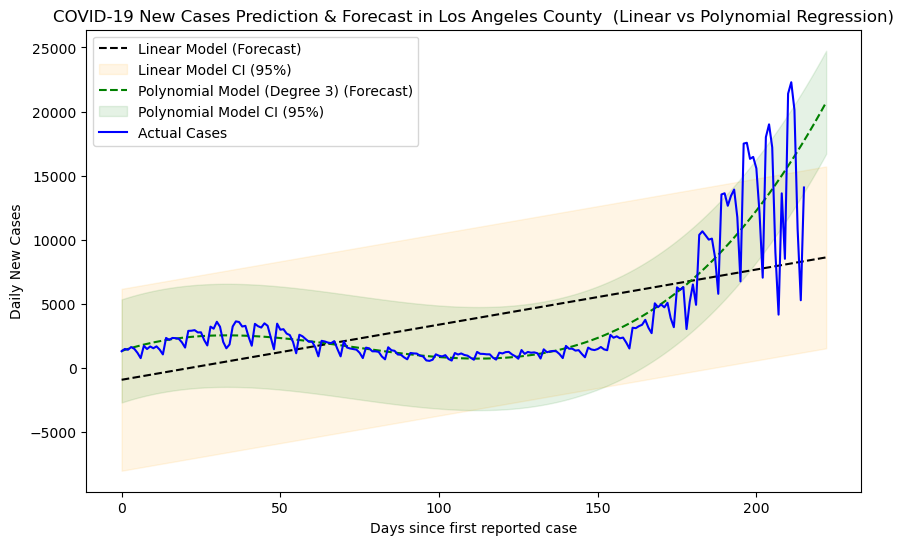

Linear RMSE for Cases in Los Angeles County : 3622.04
Polynomial RMSE for Cases in Los Angeles County : 2053.58


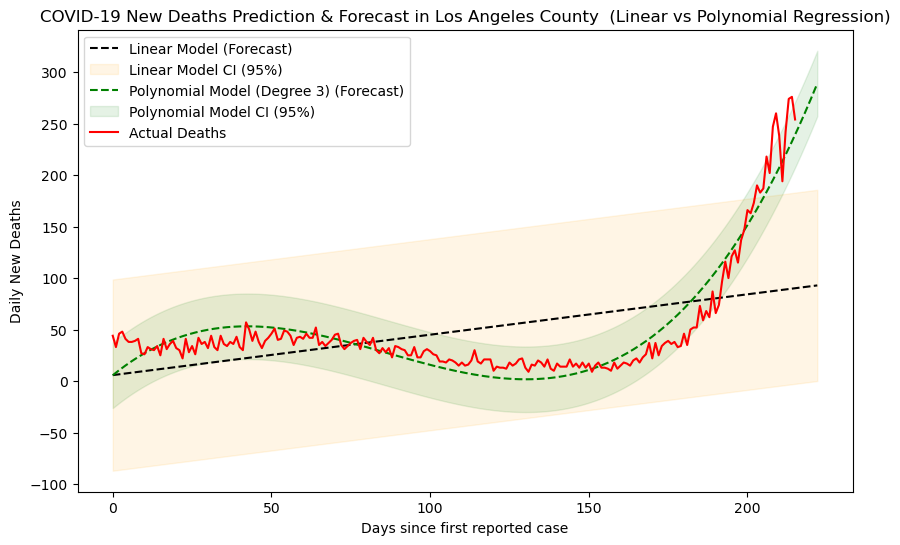

Linear RMSE for Deaths in Los Angeles County : 47.37
Polynomial RMSE for Deaths in Los Angeles County : 16.23


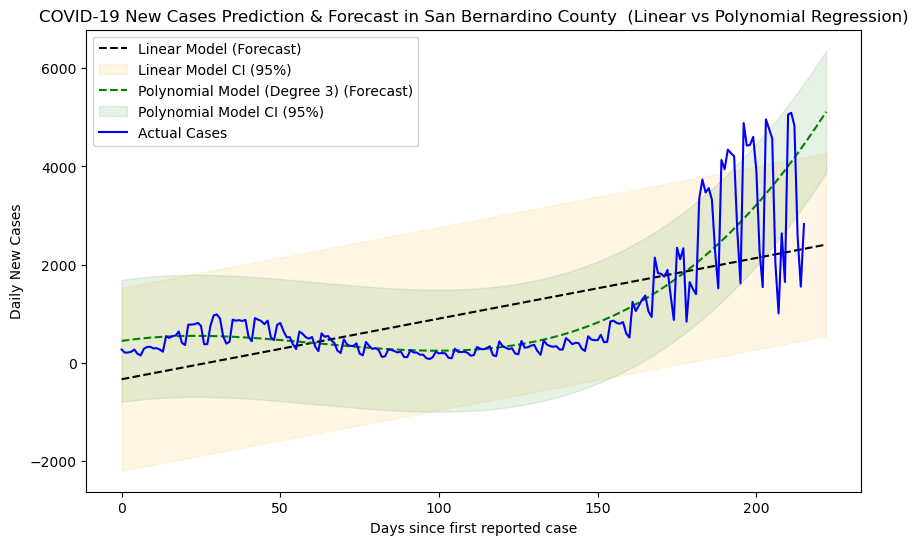

Linear RMSE for Cases in San Bernardino County : 951.27
Polynomial RMSE for Cases in San Bernardino County : 634.53


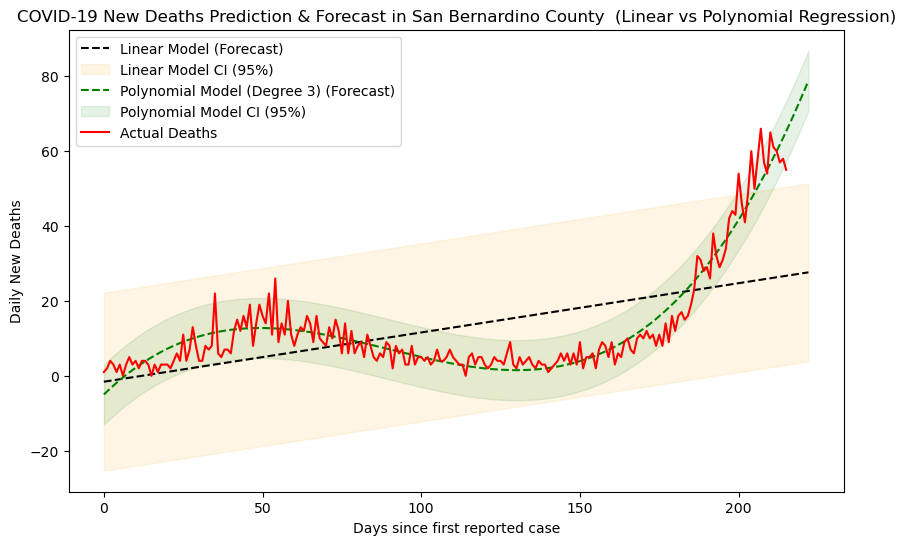

Linear RMSE for Deaths in San Bernardino County : 12.13
Polynomial RMSE for Deaths in San Bernardino County : 4.09


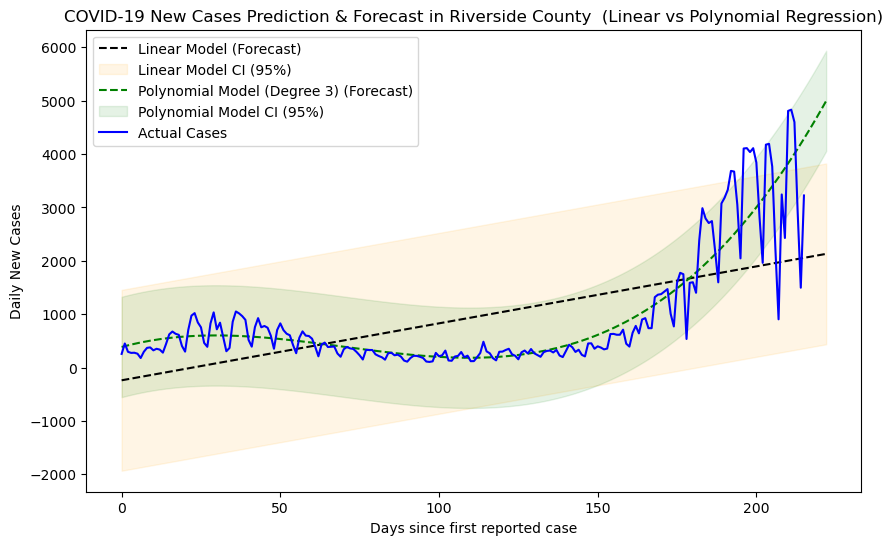

Linear RMSE for Cases in Riverside County : 864.32
Polynomial RMSE for Cases in Riverside County : 479.71


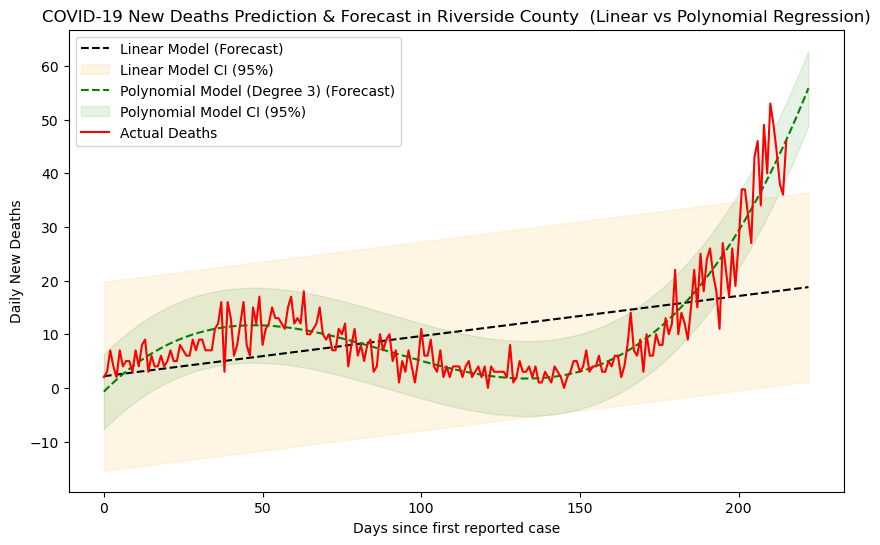

Linear RMSE for Deaths in Riverside County : 8.99
Polynomial RMSE for Deaths in Riverside County : 3.56


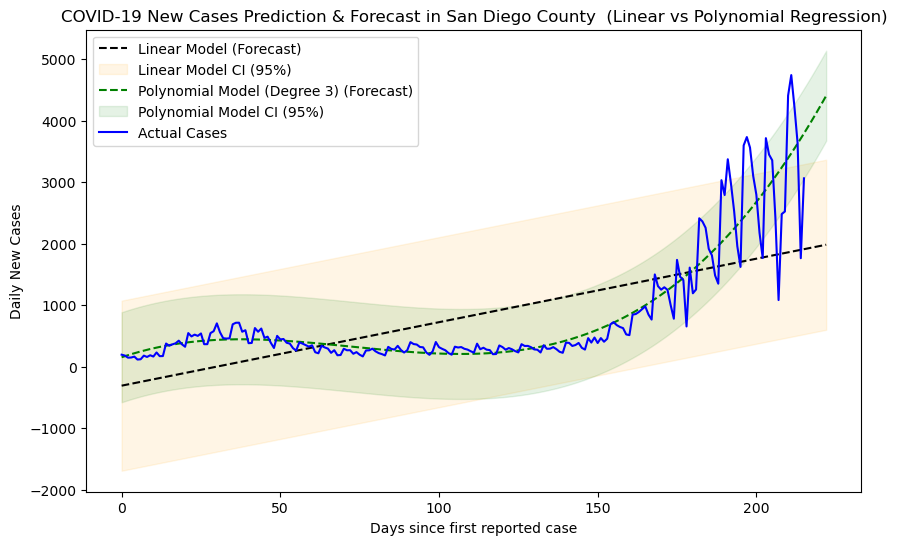

Linear RMSE for Cases in San Diego County : 705.23
Polynomial RMSE for Cases in San Diego County : 373.23


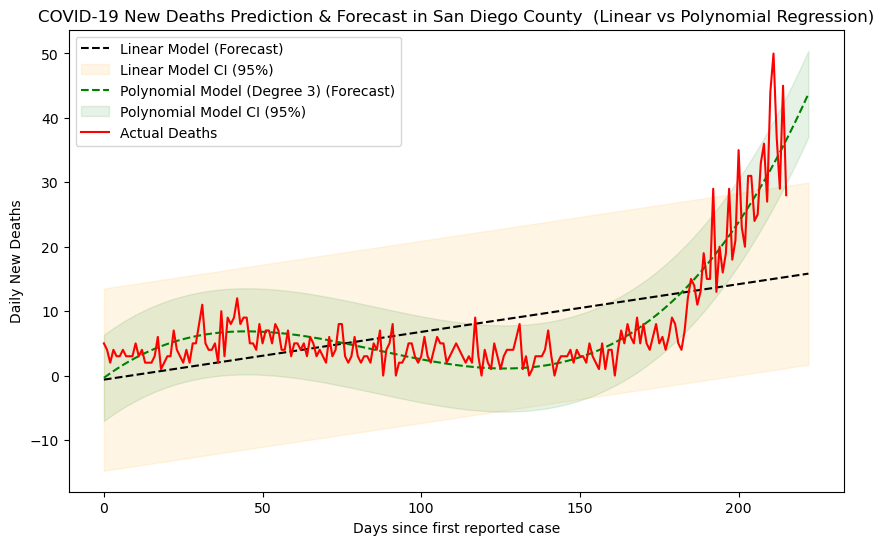

Linear RMSE for Deaths in San Diego County : 7.22
Polynomial RMSE for Deaths in San Diego County : 3.41


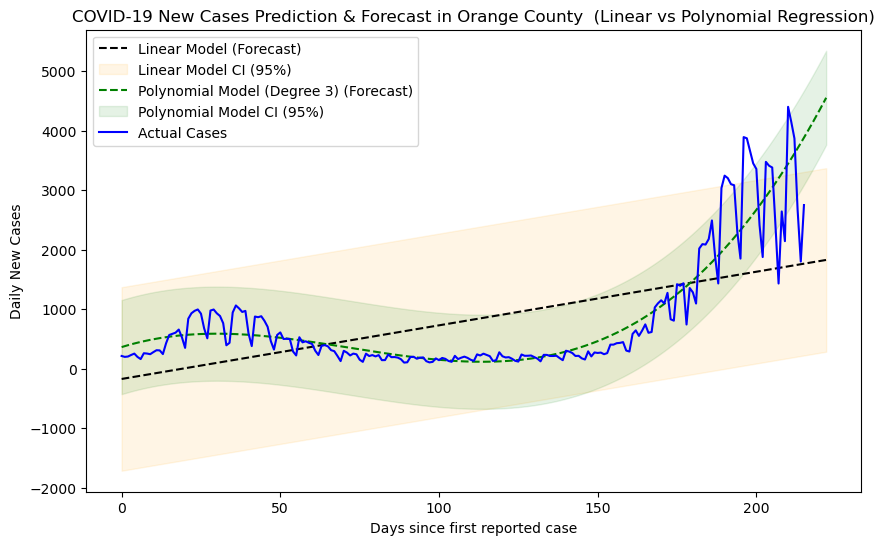

Linear RMSE for Cases in Orange County : 787.01
Polynomial RMSE for Cases in Orange County : 403.57


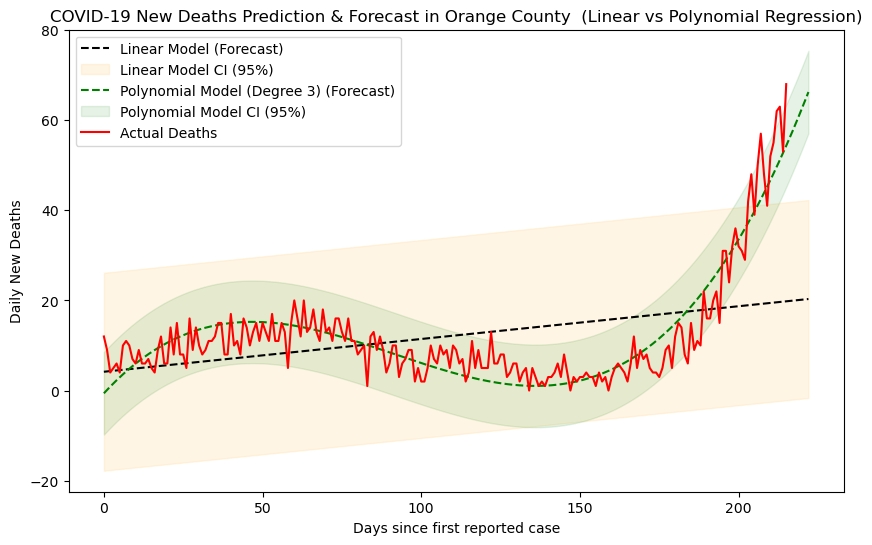

Linear RMSE for Deaths in Orange County : 11.21
Polynomial RMSE for Deaths in Orange County : 4.68


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Load the dataset
df_united_states = pd.read_csv('US-Covid.csv')

# Filter the dataset for California (State == 'CA') and explicitly make a copy
df_california = df_united_states[df_united_states['State'] == 'CA'].copy()

# Identify case and death columns
case_columns = [col for col in df_california.columns if '_cases' in col]
death_columns = [col for col in df_california.columns if '_deaths' in col]

# Calculate the total cumulative number of cases and deaths for each county
df_california.loc[:, 'total_cases'] = df_california[case_columns].iloc[:, -1]
df_california.loc[:, 'total_deaths'] = df_california[death_columns].iloc[:, -1]

# --- Get the top 5 counties by total cases ---
top_counties = df_california.nlargest(5, 'total_cases')['County Name'].tolist()

# Filter the dataset for the top 5 counties
df_top_counties = df_california[df_california['County Name'].isin(top_counties)]

# Iterate over each top county to perform RMSE analysis
for county in top_counties:
    # Filter data for the current county
    county_data = df_top_counties[df_top_counties['County Name'] == county]
    
    # Get the number of new cases for each day
    X = np.array(range(len(case_columns) - 1)).reshape(-1, 1)  # Adjusted to match the length after np.diff
    y_cases = np.diff(county_data[case_columns].values.flatten())

    # Linear Regression Model for Cases
    linear_model_cases = LinearRegression()
    linear_model_cases.fit(X, y_cases)
    y_linear_pred_cases = linear_model_cases.predict(X)
    linear_rmse_cases = np.sqrt(mean_squared_error(y_cases, y_linear_pred_cases))

    # Polynomial Regression Model (degree 3) for Cases
    poly_features_cases = PolynomialFeatures(degree=3)
    X_poly_cases = poly_features_cases.fit_transform(X)
    poly_model_cases = LinearRegression()
    poly_model_cases.fit(X_poly_cases, y_cases)
    y_poly_pred_cases = poly_model_cases.predict(X_poly_cases)
    poly_rmse_cases = np.sqrt(mean_squared_error(y_cases, y_poly_pred_cases))

    # Get the number of new deaths for each day
    y_deaths = np.diff(county_data[death_columns].values.flatten())

    # Linear Regression Model for Deaths
    linear_model_deaths = LinearRegression()
    linear_model_deaths.fit(X, y_deaths)
    y_linear_pred_deaths = linear_model_deaths.predict(X)
    linear_rmse_deaths = np.sqrt(mean_squared_error(y_deaths, y_linear_pred_deaths))

    # Polynomial Regression Model (degree 3) for Deaths
    poly_features_deaths = PolynomialFeatures(degree=3)
    X_poly_deaths = poly_features_deaths.fit_transform(X)
    poly_model_deaths = LinearRegression()
    poly_model_deaths.fit(X_poly_deaths, y_deaths)
    y_poly_pred_deaths = poly_model_deaths.predict(X_poly_deaths)
    poly_rmse_deaths = np.sqrt(mean_squared_error(y_deaths, y_poly_pred_deaths))

    # Forecast for the next 7 days for Cases and Deaths
    future_days = 7
    X_future = np.array(range(len(case_columns) - 1 + future_days)).reshape(-1, 1)

    # Predict future cases using linear and polynomial models
    y_linear_future_cases = linear_model_cases.predict(X_future)
    X_future_poly_cases = poly_features_cases.transform(X_future)
    y_poly_future_cases = poly_model_cases.predict(X_future_poly_cases)

    # Predict future deaths using linear and polynomial models
    y_linear_future_deaths = linear_model_deaths.predict(X_future)
    X_future_poly_deaths = poly_features_deaths.transform(X_future)
    y_poly_future_deaths = poly_model_deaths.predict(X_future_poly_deaths)

    # Calculate confidence intervals for the predictions (95% CI)
    def get_confidence_interval(y_true, y_pred):
        residuals = y_true - y_pred
        std_error = np.std(residuals)
        ci = 1.96 * std_error
        return ci

    ci_cases_linear = get_confidence_interval(y_cases, y_linear_pred_cases)
    ci_cases_poly = get_confidence_interval(y_cases, y_poly_pred_cases)
    ci_deaths_linear = get_confidence_interval(y_deaths, y_linear_pred_deaths)
    ci_deaths_poly = get_confidence_interval(y_deaths, y_poly_pred_deaths)

    # Plotting the forecast results for Cases
    plt.figure(figsize=(10, 6))
    plt.plot(X_future, y_linear_future_cases, color='black', linestyle='--', label='Linear Model (Forecast)')
    plt.fill_between(X_future.flatten(), y_linear_future_cases - ci_cases_linear, y_linear_future_cases + ci_cases_linear, color='orange', alpha=0.1, label='Linear Model CI (95%)')
    plt.plot(X_future, y_poly_future_cases, color='green', linestyle='--', label='Polynomial Model (Degree 3) (Forecast)')
    plt.fill_between(X_future.flatten(), y_poly_future_cases - ci_cases_poly, y_poly_future_cases + ci_cases_poly, color='green', alpha=0.1, label='Polynomial Model CI (95%)')
    plt.plot(X, y_cases, color='blue', label='Actual Cases')
    plt.xlabel('Days since first reported case')
    plt.ylabel('Daily New Cases')
    plt.title(f'COVID-19 New Cases Prediction & Forecast in {county} (Linear vs Polynomial Regression)')
    plt.legend()
    plt.show()

    print(f"Linear RMSE for Cases in {county}: {linear_rmse_cases:.2f}")
    print(f"Polynomial RMSE for Cases in {county}: {poly_rmse_cases:.2f}")

    # Plotting the forecast results for Deaths
    plt.figure(figsize=(10, 6))
    plt.plot(X_future, y_linear_future_deaths, color='black', linestyle='--', label='Linear Model (Forecast)')
    plt.fill_between(X_future.flatten(), y_linear_future_deaths - ci_deaths_linear, y_linear_future_deaths + ci_deaths_linear, color='orange', alpha=0.1, label='Linear Model CI (95%)')
    plt.plot(X_future, y_poly_future_deaths, color='green', linestyle='--', label='Polynomial Model (Degree 3) (Forecast)')
    plt.fill_between(X_future.flatten(), y_poly_future_deaths - ci_deaths_poly, y_poly_future_deaths + ci_deaths_poly, color='green', alpha=0.1, label='Polynomial Model CI (95%)')
    plt.plot(X, y_deaths, color='red', label='Actual Deaths')
    plt.xlabel('Days since first reported case')
    plt.ylabel('Daily New Deaths')
    plt.title(f'COVID-19 New Deaths Prediction & Forecast in {county} (Linear vs Polynomial Regression)')
    plt.legend()
    plt.show()

    print(f"Linear RMSE for Deaths in {county}: {linear_rmse_deaths:.2f}")
    print(f"Polynomial RMSE for Deaths in {county}: {poly_rmse_deaths:.2f}")


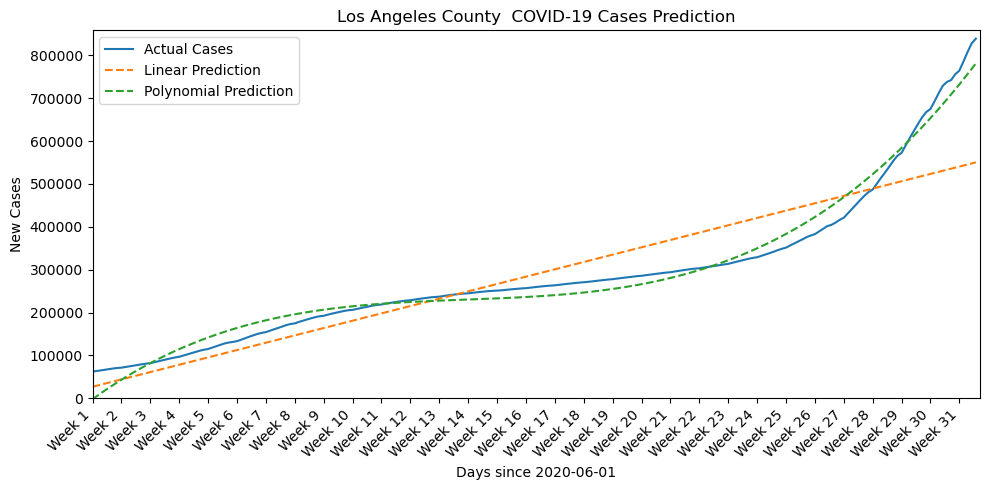

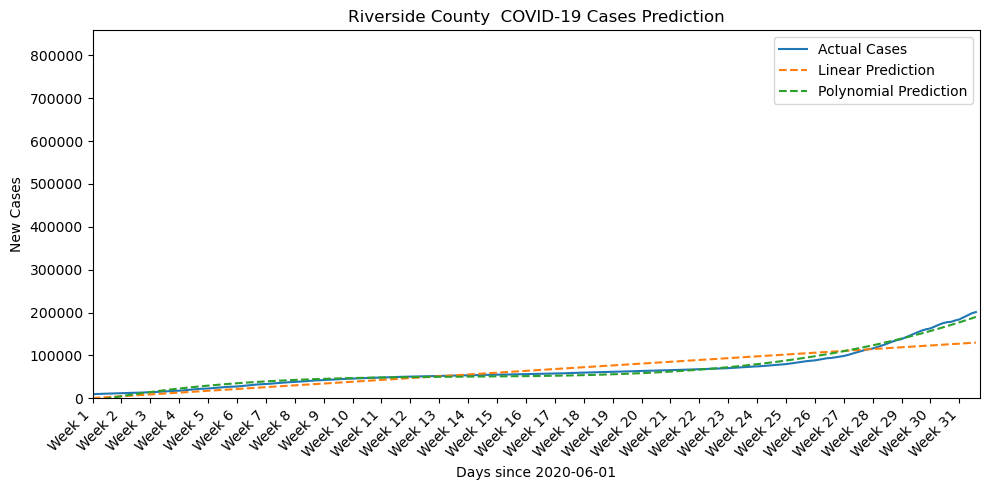

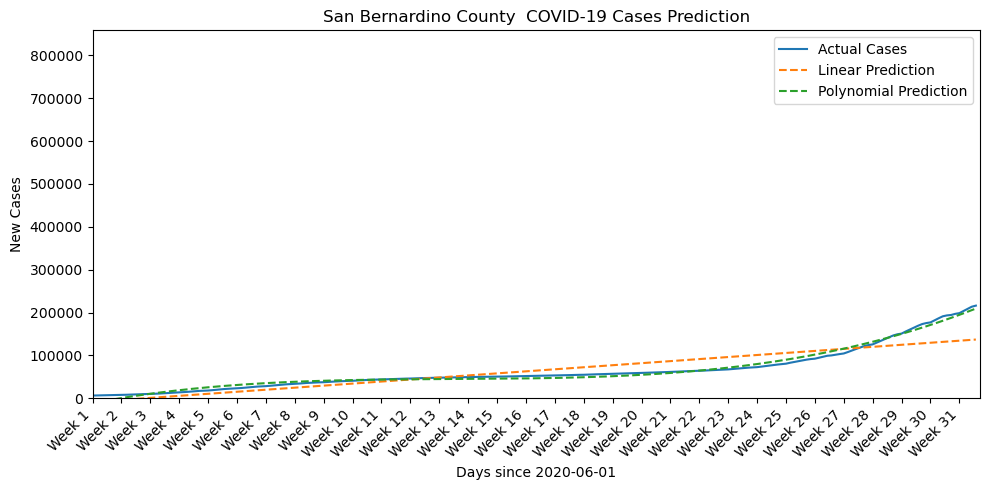

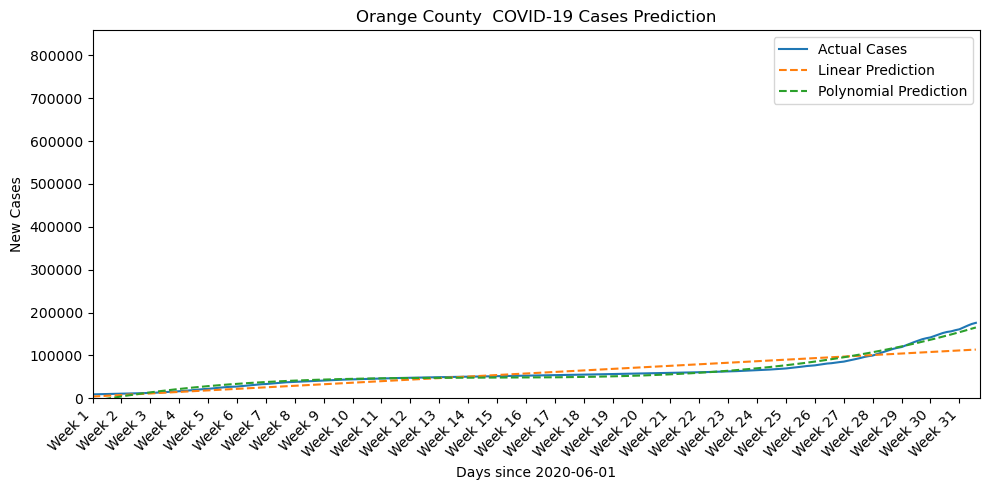

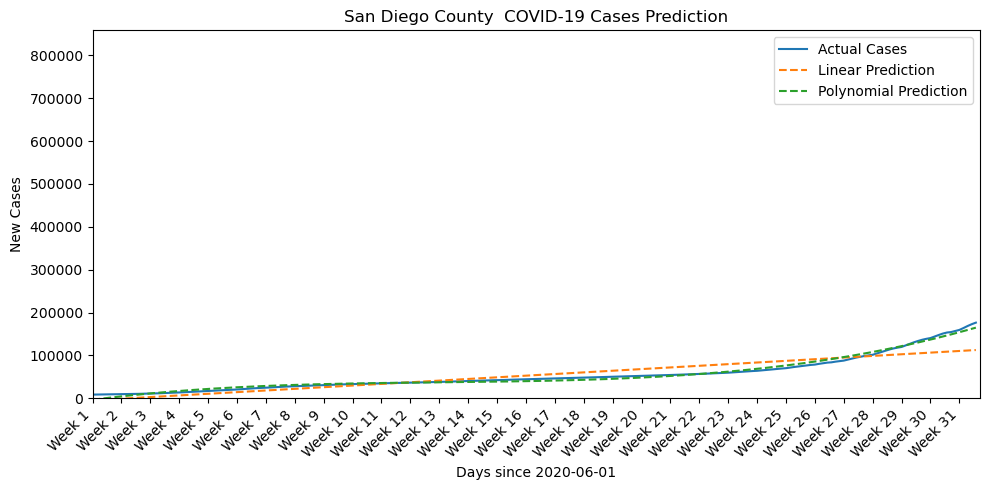

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
covid_data = pd.read_csv('US-Covid.csv')

# Filter for California and find the top 5 counties by total cases
covid_data_ca = covid_data[covid_data['State'] == 'CA']
covid_data_ca = covid_data_ca.copy()  # Create a copy of the DataFrame to work on
covid_data_ca['total_cases'] = covid_data_ca[[col for col in covid_data_ca.columns if '_cases' in col]].sum(axis=1)

top_counties = covid_data_ca.nlargest(5, 'total_cases')['County Name']

# Initialize a variable to hold the maximum y-value
max_y_value = 0

# Perform analysis for each top county
for county in top_counties:
    county_data = covid_data_ca[covid_data_ca['County Name'] == county]

    # Melt the DataFrame to long format
    county_data_long = county_data.melt(id_vars=['County Name', 'State', 'population'], 
                                         var_name='date_cases', 
                                         value_name='cases')
    
    # Extract date from the 'date_cases' column
    county_data_long['date'] = county_data_long['date_cases'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
    county_data_long['date'] = pd.to_datetime(county_data_long['date'], errors='coerce')
    
    # Drop rows where date is NaT or cases are NaN
    county_data_long = county_data_long.dropna(subset=['date', 'cases'])
    
    # Set the date as index
    county_data_long = county_data_long.set_index('date')
    
    # Prepare regression model inputs
    county_cases = county_data_long['cases'].values
    days_since_start = np.arange(len(county_cases)).reshape(-1, 1)
    X = days_since_start
    y_cases = county_cases
    
    # Update the maximum y-value if the current county's cases exceed it
    max_y_value = max(max_y_value, np.max(y_cases))

# Perform analysis for each top county again to plot with consistent y-axis
for county in top_counties:
    county_data = covid_data_ca[covid_data_ca['County Name'] == county]

    # Melt the DataFrame to long format
    county_data_long = county_data.melt(id_vars=['County Name', 'State', 'population'], 
                                         var_name='date_cases', 
                                         value_name='cases')
    
    # Extract date from the 'date_cases' column
    county_data_long['date'] = county_data_long['date_cases'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
    county_data_long['date'] = pd.to_datetime(county_data_long['date'], errors='coerce')
    
    # Drop rows where date is NaT or cases are NaN
    county_data_long = county_data_long.dropna(subset=['date', 'cases'])
    
    # Set the date as index
    county_data_long = county_data_long.set_index('date')
    
    # Prepare regression model inputs
    county_cases = county_data_long['cases'].values
    days_since_start = np.arange(len(county_cases)).reshape(-1, 1)
    X = days_since_start
    y_cases = county_cases
    
    # Limit to the next 215 days
    if len(X) > 215:
        X = X[:215]
        y_cases = y_cases[:215]

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X, y_cases)
    y_cases_pred_linear = linear_model.predict(X)
    
    # Polynomial Regression (Degree 3)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y_cases)
    y_cases_pred_poly = poly_model.predict(X_poly)
    
    # RMSE Calculation
    rmse_linear = np.sqrt(np.mean((y_cases - y_cases_pred_linear) ** 2))
    rmse_poly = np.sqrt(np.mean((y_cases - y_cases_pred_poly) ** 2))
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(X, y_cases, label="Actual Cases")
    plt.plot(X, y_cases_pred_linear, label="Linear Prediction", linestyle="--")
    plt.plot(X, y_cases_pred_poly, label="Polynomial Prediction", linestyle="--")
    plt.title(f"{county} COVID-19 Cases Prediction")
    plt.xlabel("Days since 2020-06-01")
    plt.ylabel("New Cases")
    plt.ylim(0, max_y_value)  # Set y-axis limits to the maximum value found
    plt.xlim(0, 215)  # Set x-axis limit to focus on the next 215 days
    
    # Set x-ticks to be weekly and label them
    week_labels = [f"Week {i//7 + 1}" for i in range(0, 216, 7)]  # Create labels for weeks
    plt.xticks(ticks=np.arange(0, 216, 7), labels=week_labels, rotation=45, ha='right')  # Rotate labels

    plt.legend()
    plt.tight_layout()  # Adjust layout to make room for rotated labels
    plt.show()


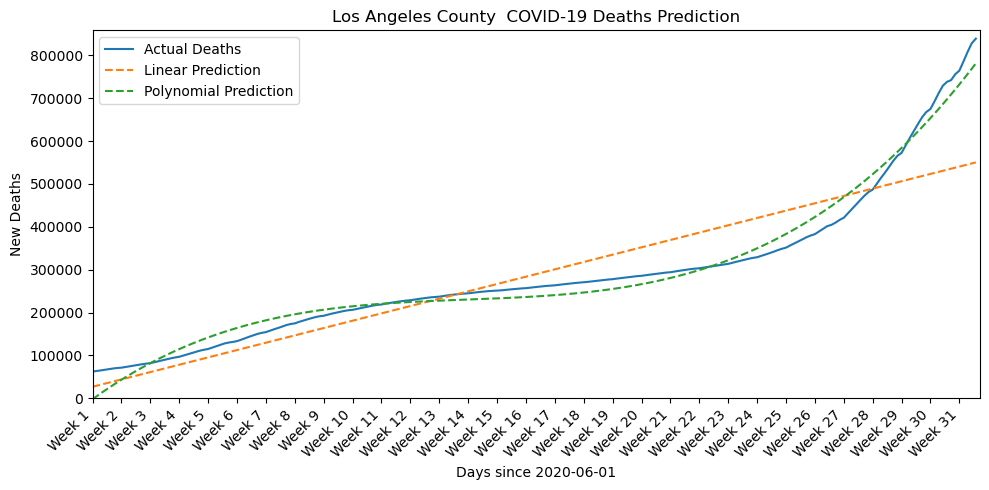

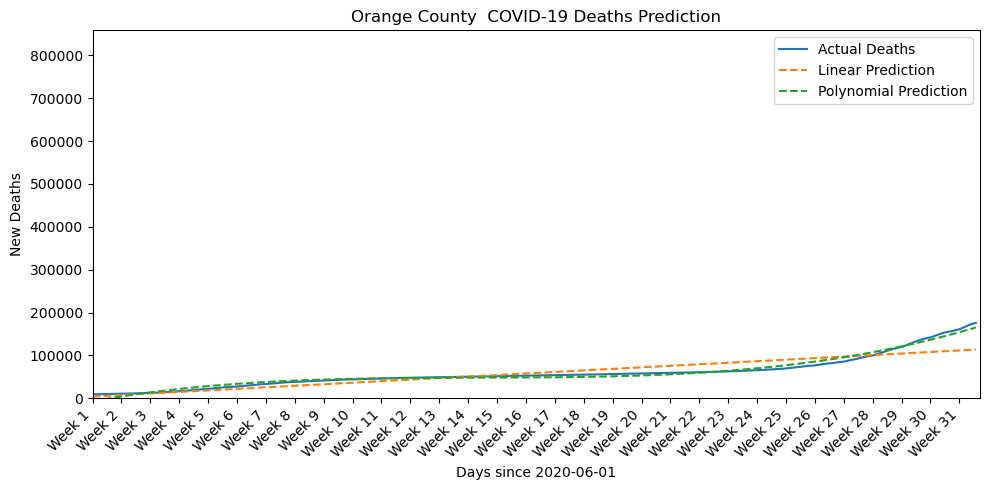

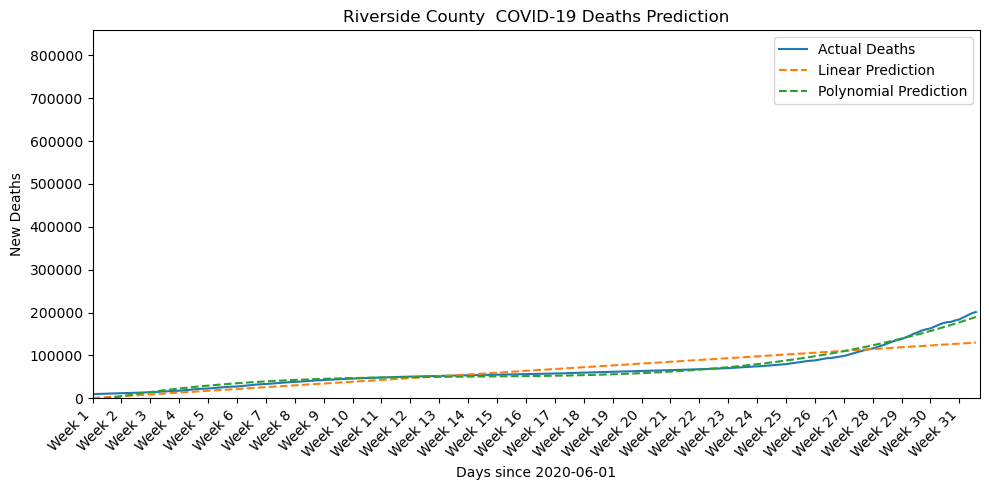

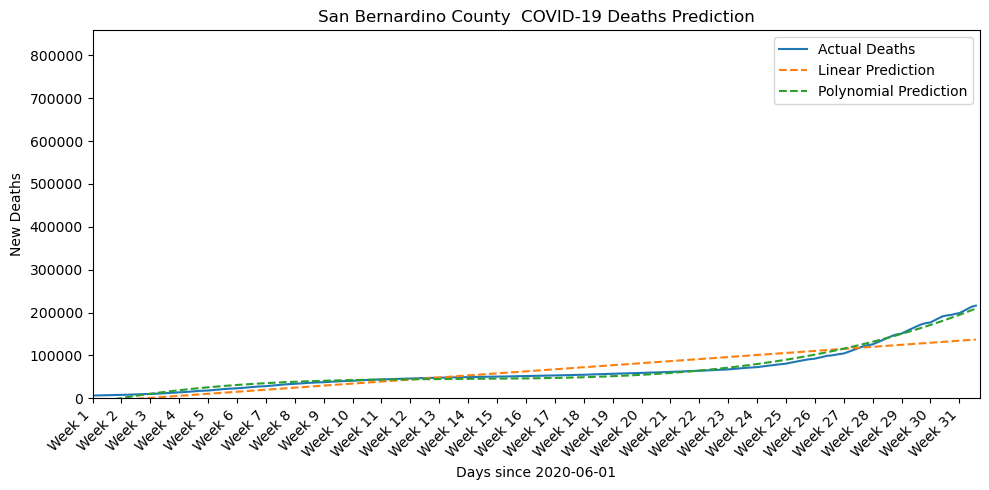

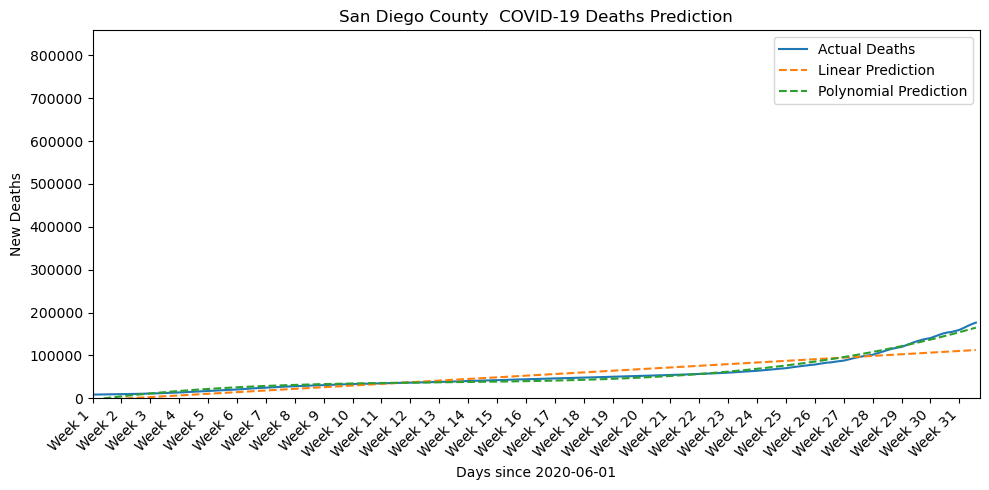

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
covid_data = pd.read_csv('US-Covid.csv')

# Filter for California and find the top 5 counties by total deaths
covid_data_ca = covid_data[covid_data['State'] == 'CA']
covid_data_ca = covid_data_ca.copy()  # Create a copy of the DataFrame to work on
covid_data_ca['total_deaths'] = covid_data_ca[[col for col in covid_data_ca.columns if '_deaths' in col]].sum(axis=1)

top_counties = covid_data_ca.nlargest(5, 'total_deaths')['County Name']

# Initialize a variable to hold the maximum y-value
max_y_value = 0

# Perform analysis for each top county
for county in top_counties:
    county_data = covid_data_ca[covid_data_ca['County Name'] == county]

    # Melt the DataFrame to long format for deaths
    county_data_long = county_data.melt(id_vars=['County Name', 'State', 'population'], 
                                         var_name='date_deaths', 
                                         value_name='deaths')
    
    # Extract date from the 'date_deaths' column
    county_data_long['date'] = county_data_long['date_deaths'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
    county_data_long['date'] = pd.to_datetime(county_data_long['date'], errors='coerce')
    
    # Drop rows where date is NaT or deaths are NaN
    county_data_long = county_data_long.dropna(subset=['date', 'deaths'])
    
    # Set the date as index
    county_data_long = county_data_long.set_index('date')
    
    # Prepare regression model inputs
    county_deaths = county_data_long['deaths'].values
    days_since_start = np.arange(len(county_deaths)).reshape(-1, 1)
    X = days_since_start
    y_deaths = county_deaths
    
    # Update the maximum y-value if the current county's deaths exceed it
    max_y_value = max(max_y_value, np.max(y_deaths))

# Perform analysis for each top county again to plot with consistent y-axis
for county in top_counties:
    county_data = covid_data_ca[covid_data_ca['County Name'] == county]

    # Melt the DataFrame to long format for deaths
    county_data_long = county_data.melt(id_vars=['County Name', 'State', 'population'], 
                                         var_name='date_deaths', 
                                         value_name='deaths')
    
    # Extract date from the 'date_deaths' column
    county_data_long['date'] = county_data_long['date_deaths'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
    county_data_long['date'] = pd.to_datetime(county_data_long['date'], errors='coerce')
    
    # Drop rows where date is NaT or deaths are NaN
    county_data_long = county_data_long.dropna(subset=['date', 'deaths'])
    
    # Set the date as index
    county_data_long = county_data_long.set_index('date')
    
    # Prepare regression model inputs
    county_deaths = county_data_long['deaths'].values
    days_since_start = np.arange(len(county_deaths)).reshape(-1, 1)
    X = days_since_start
    y_deaths = county_deaths
    
    # Limit to the next 215 days
    if len(X) > 215:
        X = X[:215]
        y_deaths = y_deaths[:215]

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X, y_deaths)
    y_deaths_pred_linear = linear_model.predict(X)
    
    # Polynomial Regression (Degree 3)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y_deaths)
    y_deaths_pred_poly = poly_model.predict(X_poly)
    
    # RMSE Calculation
    rmse_linear = np.sqrt(np.mean((y_deaths - y_deaths_pred_linear) ** 2))
    rmse_poly = np.sqrt(np.mean((y_deaths - y_deaths_pred_poly) ** 2))
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(X, y_deaths, label="Actual Deaths")
    plt.plot(X, y_deaths_pred_linear, label="Linear Prediction", linestyle="--")
    plt.plot(X, y_deaths_pred_poly, label="Polynomial Prediction", linestyle="--")
    plt.title(f"{county} COVID-19 Deaths Prediction")
    plt.xlabel("Days since 2020-06-01")
    plt.ylabel("New Deaths")
    plt.xlim(0, 215)  # Set x-axis limit to focus on the next 215 days
    
    # Set x-ticks to be weekly and label them
    week_labels = [f"Week {i//7 + 1}" for i in range(0, 216, 7)]  # Create labels for weeks
    plt.xticks(ticks=np.arange(0, 216, 7), labels=week_labels, rotation=45, ha='right')  # Rotate labels

    plt.ylim(0, max_y_value)  # Set y-axis limits to the maximum value found
    plt.legend()
    plt.tight_layout()  # Adjust layout to make room for rotated labels
    plt.show()


# First Part Complete Above

In [34]:
import pandas as pd
import numpy as np
from scipy import stats

# Load enrichment data and COVID data for California
enrichment_data = pd.read_csv('Economy.csv')
covid_data = pd.read_csv(r"C:\Users\bluev\Downloads\Group7ClassProject\Stage II\Hamza Ahmed\filtered_super_dates_June2020_Jan2021_and_6_states.csv")

# Step 1: Reshape enrichment data to make rows into columns
# Filter rows that are of interest and pivot them into a single-row DataFrame
columns_of_interest = ["Civilian labor force", "Employed", "With health insurance coverage"]
enrichment_data_filtered = enrichment_data[enrichment_data['Label (Grouping)'].isin(columns_of_interest)]
enrichment_data_pivoted = enrichment_data_filtered.pivot_table(
    index=None,
    columns="Label (Grouping)",
    values="California!!Estimate"  # Adjust if necessary to use the correct state's column
).reset_index(drop=True)

# Step 2: Add California average cases per 100k to the pivoted DataFrame
covid_data_ca = covid_data[covid_data['State'] == 'CA'].copy()
covid_data_ca['total_cases'] = covid_data_ca[[col for col in covid_data_ca.columns if '_cases' in col]].sum(axis=1)
covid_data_ca['cases_per_100k'] = (covid_data_ca['total_cases'] / covid_data_ca['population']) * 100000
california_avg_cases_per_100k = covid_data_ca['cases_per_100k'].mean()
enrichment_data_pivoted['cases_per_100k'] = california_avg_cases_per_100k

# Step 3: Define T-test function
def perform_t_test(data, enrichment_column, outcome_column='cases_per_100k'):
    if enrichment_column not in data.columns:
        print(f"{enrichment_column} column not found in enrichment data.")
        return
    
    median_value = data[enrichment_column].median()
    high_group = data[data[enrichment_column] > median_value][outcome_column]
    low_group = data[data[enrichment_column] <= median_value][outcome_column]
    
    t_stat, p_value = stats.ttest_ind(high_group, low_group, equal_var=False)
    print(f"T-test for {enrichment_column}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# Step 4: Perform T-tests for selected variables
for column in columns_of_interest:
    perform_t_test(enrichment_data_pivoted, column)


Civilian labor force column not found in enrichment data.
Employed column not found in enrichment data.
With health insurance coverage column not found in enrichment data.


# Next Part

# Here you see I'm getting some weird values in the results

In [37]:
import pandas as pd

# Load your enrichment dataset
enrichment_data = pd.read_csv('Economy.csv')

# Check unique values in the 'Label (Grouping)' column
print(enrichment_data['Label (Grouping)'].unique())

# Attempt to extract values for the hypotheses
try:
    civilian_labor_force = enrichment_data.loc[enrichment_data['Label (Grouping)'].str.strip() == 'Civilian labor force', 'California!!Estimate'].values[0]
    employed = enrichment_data.loc[enrichment_data['Label (Grouping)'].str.strip() == 'Employed', 'California!!Estimate'].values[0]
    health_insurance_coverage = enrichment_data.loc[enrichment_data['Label (Grouping)'].str.strip() == 'With health insurance coverage', 'California!!Estimate'].values[0]
except IndexError as e:
    print("IndexError: Could not find one of the labels in the enrichment dataset.")
    print(e)

# Print the extracted values to confirm they were obtained correctly
print(f'Civilian Labor Force: {civilian_labor_force}')
print(f'Employed: {employed}')
print(f'Health Insurance Coverage: {health_insurance_coverage}')


['EMPLOYMENT STATUS' '\xa0\xa0\xa0\xa0Population 16 years and over'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0In labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Civilian labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Employed'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployed'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Armed Forces'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Not in labor force'
 '\xa0\xa0\xa0\xa0Civilian labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployment Rate'
 '\xa0\xa0\xa0\xa0Females 16 years and over'
 '\xa0\xa0\xa0\xa0Own children of the householder under 6 years'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0All parents in family in labor force'
 '\xa0\xa0\xa0\xa0Own children of the householder 6 to 17 years'
 'COMMUTING TO WORK' '\xa0\xa0\xa0\xa0Workers 16 years and over'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Car, truck, or van -- drove alone'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Car, truck, or van -- carpoole

In [38]:
import pandas as pd

# Load the datasets
enrichment_data = pd.read_csv(r"C:\Users\bluev\OneDrive\Documents\Economy.csv")
covid_data = pd.read_csv('US-Covid.csv')
print(enrichment_data.columns)
print(enrichment_data['Label (Grouping)'].unique())
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip()
filtered_data = enrichment_data[enrichment_data['Label (Grouping)'] == 'Civilian labor force']
print(filtered_data)

# Clean the column names by stripping whitespace
enrichment_data.columns = enrichment_data.columns.str.strip()

# Extract relevant values from the enrichment dataset
civilian_labor_force = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'Civilian labor force', 'California!!Estimate'].values[0]
employed = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'Employed', 'California!!Estimate'].values[0]
health_insurance_coverage = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'With health insurance coverage', 'California!!Estimate'].values[0]

print(f"Civilian Labor Force: {civilian_labor_force}")
print(f"Employed: {employed}")
print(f"Health Insurance Coverage: {health_insurance_coverage}")


Index(['Label (Grouping)', 'California!!Estimate', 'California!!Percent'], dtype='object')
['EMPLOYMENT STATUS' '\xa0\xa0\xa0\xa0Population 16 years and over'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0In labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Civilian labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Employed'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployed'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Armed Forces'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Not in labor force'
 '\xa0\xa0\xa0\xa0Civilian labor force'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployment Rate'
 '\xa0\xa0\xa0\xa0Females 16 years and over'
 '\xa0\xa0\xa0\xa0Own children of the householder under 6 years'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0All parents in family in labor force'
 '\xa0\xa0\xa0\xa0Own children of the householder 6 to 17 years'
 'COMMUTING TO WORK' '\xa0\xa0\xa0\xa0Workers 16 years and over'
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Car, tru

In [39]:
import pandas as pd

# Load the datasets
enrichment_data = pd.read_csv('Economy.csv')
covid_data = pd.read_csv('US-Covid.csv')

# Clean the column names by stripping whitespace
enrichment_data.columns = enrichment_data.columns.str.strip()

# Clean 'Label (Grouping)' values by stripping whitespace and removing any non-breaking spaces
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip().replace(r'\xa0', '', regex=True)

# Check the unique values again after cleaning
print(enrichment_data['Label (Grouping)'].unique())

# Extract relevant values from the enrichment dataset
civilian_labor_force = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'Civilian labor force', 'California!!Estimate'].values[0]
employed = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'Employed', 'California!!Estimate'].values[0]
health_insurance_coverage = enrichment_data.loc[enrichment_data['Label (Grouping)'] == 'With health insurance coverage', 'California!!Estimate'].values[0]

print(f"Civilian Labor Force: {civilian_labor_force}")
print(f"Employed: {employed}")
print(f"Health Insurance Coverage: {health_insurance_coverage}")


['EMPLOYMENT STATUS' 'Population 16 years and over' 'In labor force'
 'Civilian labor force' 'Employed' 'Unemployed' 'Armed Forces'
 'Not in labor force' 'Unemployment Rate' 'Females 16 years and over'
 'Own children of the householder under 6 years'
 'All parents in family in labor force'
 'Own children of the householder 6 to 17 years' 'COMMUTING TO WORK'
 'Workers 16 years and over' 'Car, truck, or van -- drove alone'
 'Car, truck, or van -- carpooled'
 'Public transportation (excluding taxicab)' 'Walked' 'Other means'
 'Worked from home' 'Mean travel time to work (minutes)' 'OCCUPATION'
 'Civilian employed population 16 years and over'
 'Management, business, science, and arts occupations'
 'Service occupations' 'Sales and office occupations'
 'Natural resources, construction, and maintenance occupations'
 'Production, transportation, and material moving occupations' 'INDUSTRY'
 'Agriculture, forestry, fishing and hunting, and mining' 'Construction'
 'Manufacturing' 'Wholesale trad

# First Attempt

In [42]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime

# Load your datasets
enrichment_data = pd.read_csv('Economy.csv')
covid_data = pd.read_csv('US-Covid.csv')

# Normalize strings in the 'Label (Grouping)' column
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip().str.lower()

# Function to get values safely and ensure they are numeric
def get_value(label):
    try:
        value = enrichment_data.loc[
            enrichment_data['Label (Grouping)'] == label.lower(),
            'California!!Estimate'
        ].values[0]
        return pd.to_numeric(value, errors='coerce')  # Convert to numeric
    except IndexError:
        print(f"Warning: No data found for '{label}'")
        return None

# Extract relevant values from the enrichment dataset
civilian_labor_force = get_value('Civilian labor force')
employed = get_value('Employed')
health_insurance_coverage = get_value('With health insurance coverage')

# Check if any of the values are None and handle accordingly
if civilian_labor_force is None or employed is None or health_insurance_coverage is None:
    print("One or more required values are missing. Please check the enrichment dataset.")
else:
    # Get the current date and end date
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = '2021-01-03'

    # Generate a list of relevant date columns within the date range
    date_columns = [date for date in covid_data.columns if start_date <= date <= end_date]

    # Check if date_columns is empty
    if not date_columns:
        print("No date columns found within the specified date range.")
    else:
        # Filter COVID-19 data for relevant dates
        covid_data_filtered = covid_data[['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'] + date_columns]

        # Hypothesis Testing Function
        def perform_hypothesis_test(covid_data, employment_value, date_columns):
            # Get average cases per 10,000 population for the specified date range
            covid_cases_per_10k = covid_data[date_columns].sum(axis=1) / (covid_data['population'] / 10000)

            # Check for NaN values in covid_cases_per_10k
            if covid_cases_per_10k.isnull().all():
                print("All COVID cases per 10,000 are NaN.")
                return np.nan, np.nan, covid_cases_per_10k

            # Create high and low groups based on employment value
            mean_cases = covid_cases_per_10k.mean()
            print(f"Mean cases for employment value {employment_value}: {mean_cases}")

            # Ensure employment_value is a float
            employment_value = float(employment_value)

            # Separate cases into high and low based on mean cases
            if employment_value > mean_cases:
                high_cases = covid_cases_per_10k[covid_cases_per_10k > mean_cases]
                low_cases = covid_cases_per_10k[covid_cases_per_10k <= mean_cases]
            else:
                high_cases = covid_cases_per_10k[covid_cases_per_10k <= mean_cases]
                low_cases = covid_cases_per_10k[covid_cases_per_10k > mean_cases]

            # Print the groups
            print(f"High cases for employment value {employment_value}: {high_cases}")
            print(f"Low cases for employment value {employment_value}: {low_cases}")

            # Check if either group is empty
            if high_cases.empty or low_cases.empty:
                print("One of the groups is empty. High cases or low cases may not have enough data.")
                return np.nan, np.nan, covid_cases_per_10k

            # Perform two-sample t-test
            t_stat, p_value = stats.ttest_ind(high_cases, low_cases, equal_var=False)  # Welch's t-test
            return t_stat, p_value, covid_cases_per_10k

        # Perform hypothesis tests
        t_stat_civilian, p_value_civilian, cases_civilian = perform_hypothesis_test(covid_data_filtered, civilian_labor_force, date_columns)
        print(f'Civilian Labor Force - T-statistic: {t_stat_civilian}, P-value: {p_value_civilian}')

        t_stat_employed, p_value_employed, cases_employed = perform_hypothesis_test(covid_data_filtered, employed, date_columns)
        print(f'Employed - T-statistic: {t_stat_employed}, P-value: {p_value_employed}')

        t_stat_health_insurance, p_value_health_insurance, cases_health_insurance = perform_hypothesis_test(covid_data_filtered, health_insurance_coverage, date_columns)
        print(f'Health Insurance Coverage - T-statistic: {t_stat_health_insurance}, P-value: {p_value_health_insurance}')

        # Function to plot hypothesis results
        def plot_hypothesis_results(cases_per_10k, employment_value, label):
            plt.figure(figsize=(12, 6))  # Increase figure size for better readability
            plt.title(f'COVID-19 Cases Based on {label}')

            # Drop NaN values to avoid plotting issues
            cases_per_10k = cases_per_10k.dropna()

            # Create histogram with more bins and adjusted range
            plt.hist(cases_per_10k, bins=50, alpha=0.7, color='blue', label='COVID-19 Cases per 10,000')

            # Add a vertical line for employment value
            plt.axvline(employment_value, color='red', linestyle='dashed', linewidth=2, label='Employment Threshold')

            # Set x-axis limits (adjust these values based on your data range)
            plt.xlim(0, cases_per_10k.max() + 5)  # Add a little padding

            # Adding grid lines for better readability
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Set labels and legend
            plt.xlabel('Cases per 10,000')
            plt.ylabel('Frequency')
            plt.legend()
            plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
            plt.show()

        


Mean cases for employment value nan: 691.8184881658256
High cases for employment value nan: 1       637.582089
2       633.152394
9       557.336998
11      409.087298
18      498.921504
           ...    
3130    476.550681
3132    606.960951
3134    544.501370
3136    615.400264
3141    691.497041
Length: 1661, dtype: float64
Low cases for employment value nan: 0        779.502049
3        860.944896
4        831.632830
5        912.780913
6        818.078980
           ...     
3135     849.598163
3137     717.001630
3138     921.837709
3139     779.689509
3140    1027.546445
Length: 1481, dtype: float64
Civilian Labor Force - T-statistic: -63.53384696017083, P-value: 0.0
Mean cases for employment value nan: 691.8184881658256
High cases for employment value nan: 1       637.582089
2       633.152394
9       557.336998
11      409.087298
18      498.921504
           ...    
3130    476.550681
3132    606.960951
3134    544.501370
3136    615.400264
3141    691.497041
Length: 1661, d

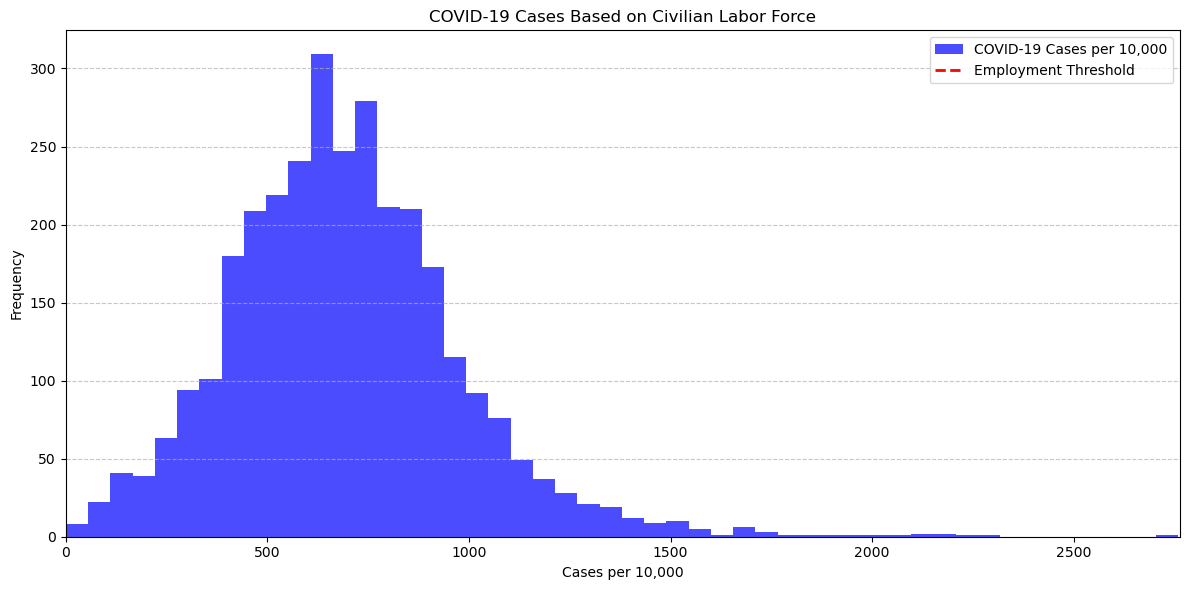

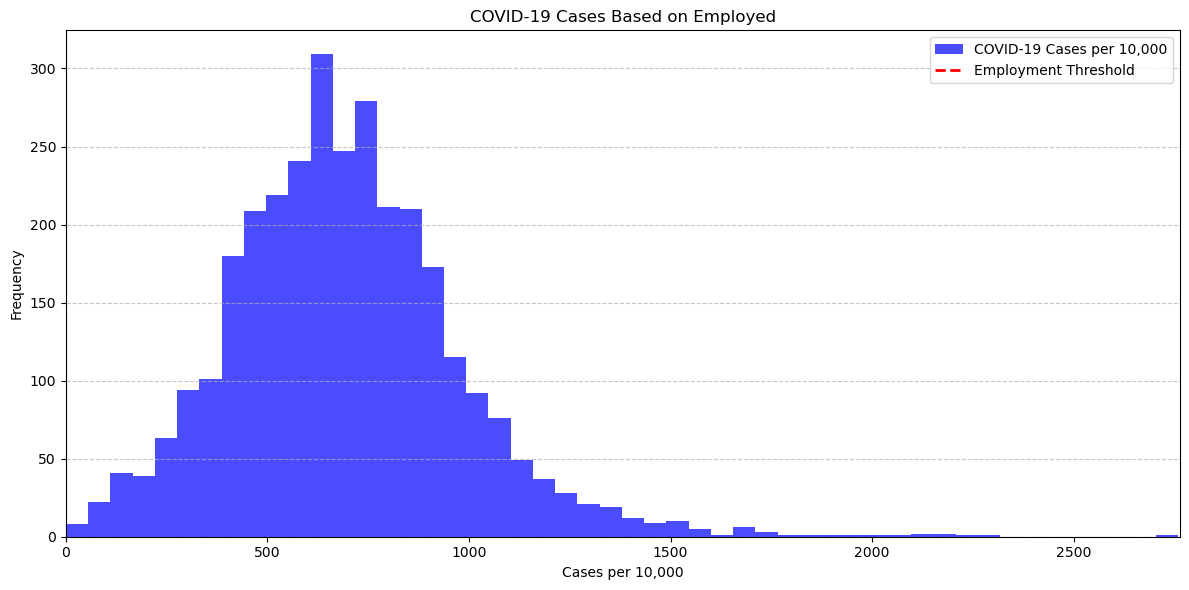

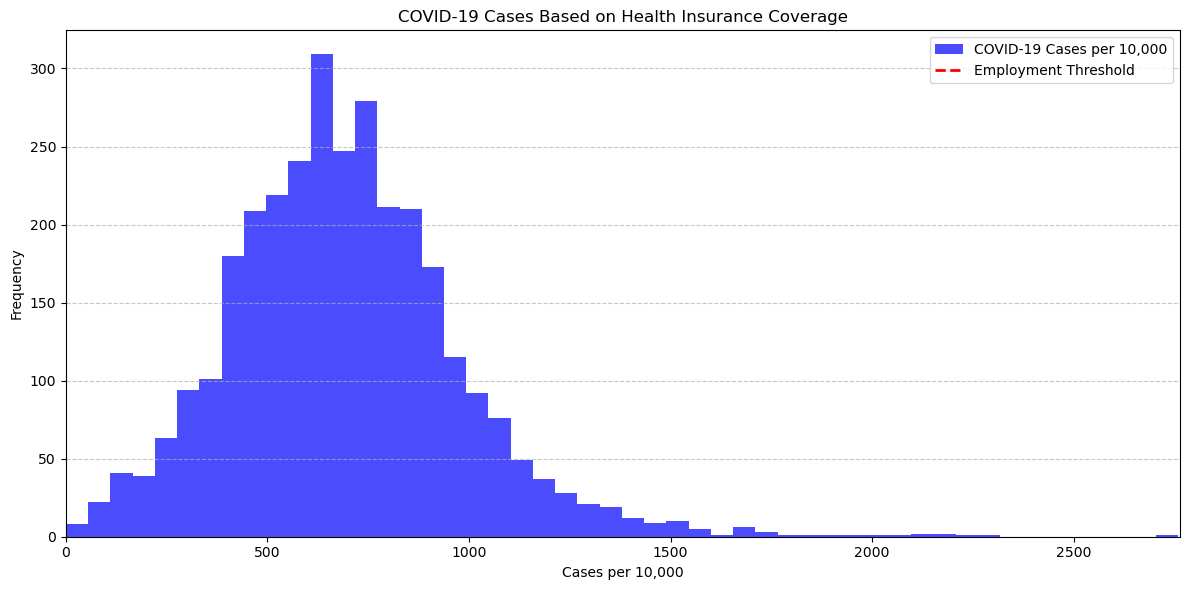

In [43]:
# Plot results for each hypothesis with appropriate labels
plot_hypothesis_results(cases_civilian, civilian_labor_force, 'Civilian Labor Force')
plot_hypothesis_results(cases_employed, employed, 'Employed')
plot_hypothesis_results(cases_health_insurance, health_insurance_coverage, 'Health Insurance Coverage')

# Attempting to graph

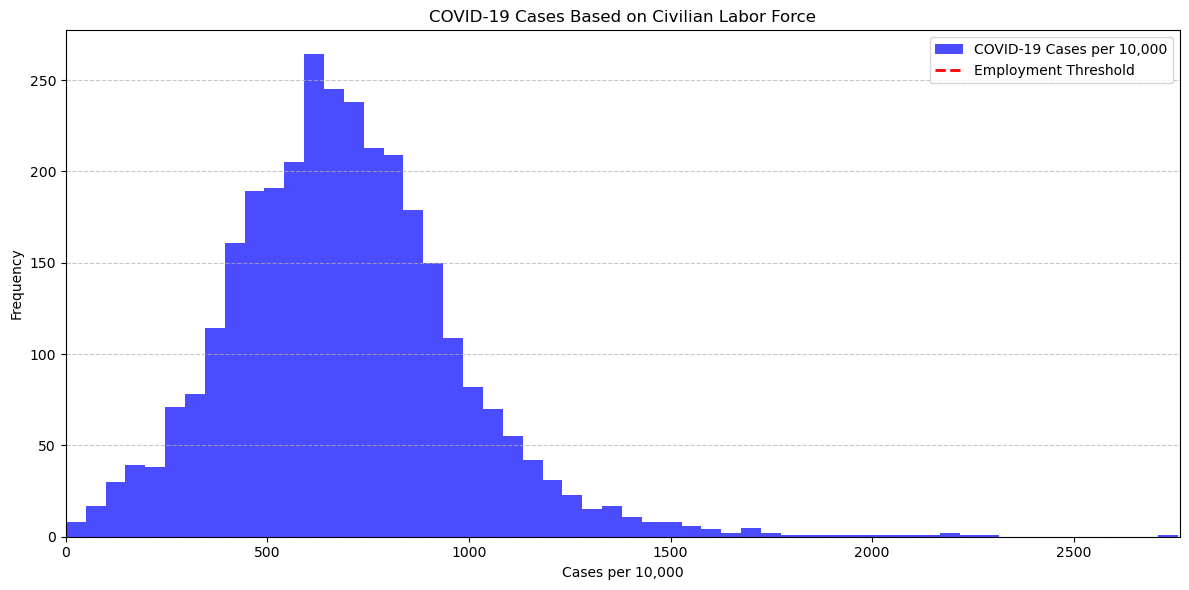

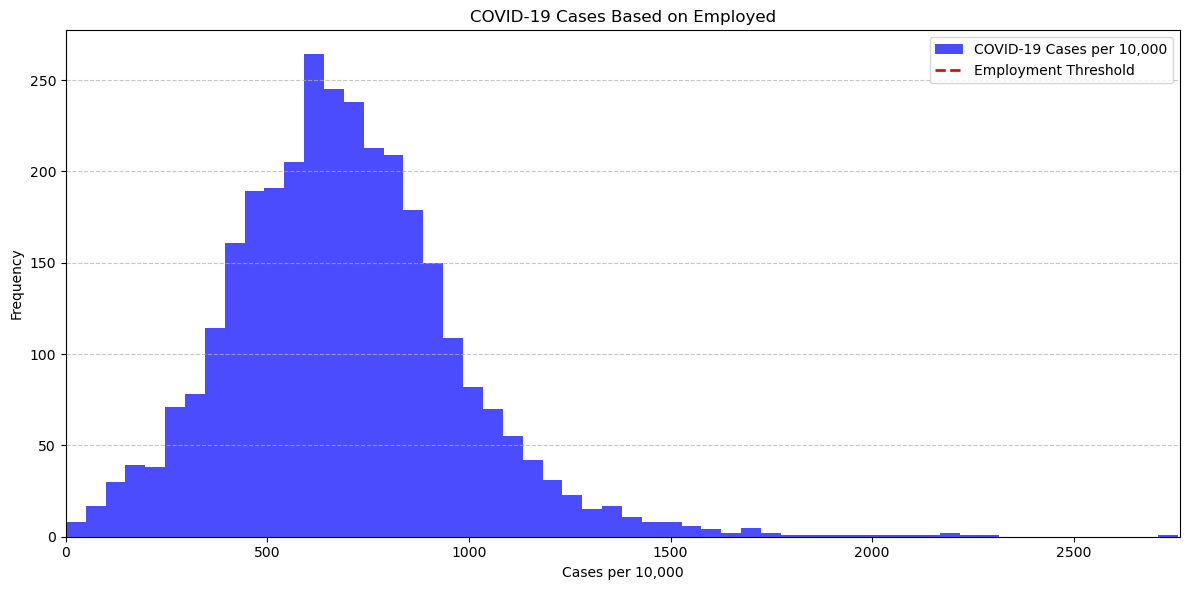

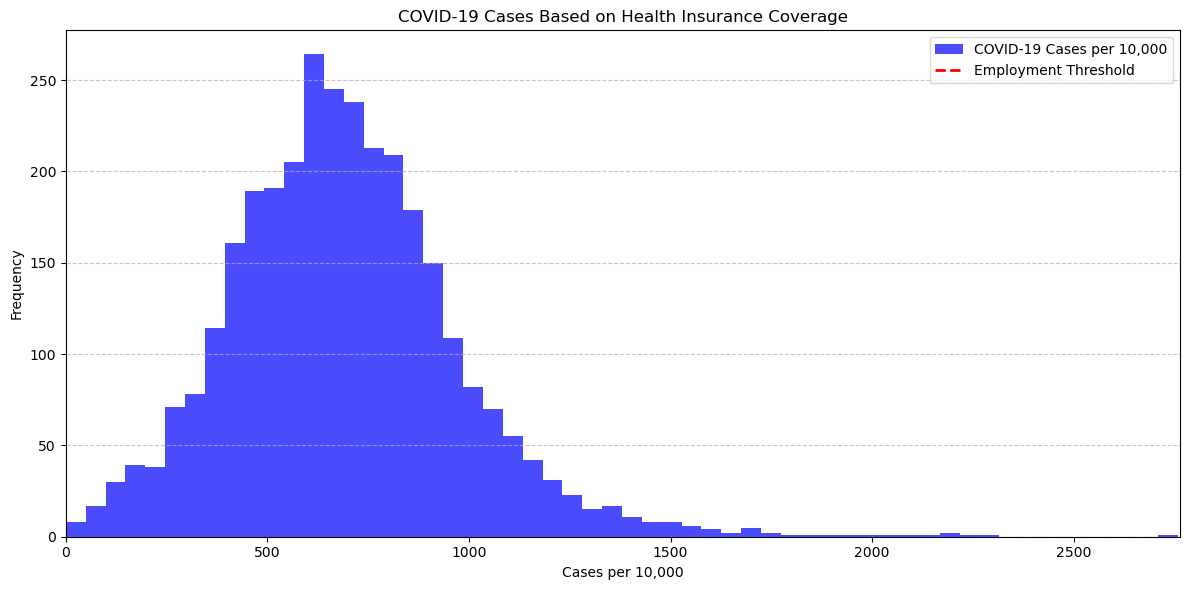

In [46]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime

# Load datasets
enrichment_data = pd.read_csv('Economy.csv')
covid_data = pd.read_csv('US-Covid.csv')

# Normalize strings in 'Label (Grouping)' column
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip().str.lower()

# Function to get values safely and ensure they are numeric
def get_value(label):
    try:
        value = enrichment_data.loc[
            enrichment_data['Label (Grouping)'] == label.lower(),
            'California!!Estimate'
        ].values[0]
        return pd.to_numeric(value, errors='coerce')
    except IndexError:
        print(f"Warning: No data found for '{label}'")
        return None

# Extract values
civilian_labor_force = get_value('Civilian labor force')
employed = get_value('Employed')
health_insurance_coverage = get_value('With health insurance coverage')

# Define start and end dates for COVID data filtering
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = '2021-01-03'
date_columns = [date for date in covid_data.columns if start_date <= date <= end_date]

# Filter COVID-19 data for relevant dates
covid_data_filtered = covid_data[['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'] + date_columns]

# Hypothesis Testing Function
def perform_hypothesis_test(covid_data, employment_value, date_columns):
    covid_cases_per_10k = covid_data[date_columns].sum(axis=1) / (covid_data['population'] / 10000)

    if covid_cases_per_10k.isnull().all():
        print("All COVID cases per 10,000 are NaN.")
        return np.nan, np.nan, covid_cases_per_10k

    mean_cases = covid_cases_per_10k.mean()
    employment_value = float(employment_value)

    if employment_value > mean_cases:
        high_cases = covid_cases_per_10k[covid_cases_per_10k > mean_cases]
        low_cases = covid_cases_per_10k[covid_cases_per_10k <= mean_cases]
    else:
        high_cases = covid_cases_per_10k[covid_cases_per_10k <= mean_cases]
        low_cases = covid_cases_per_10k[covid_cases_per_10k > mean_cases]

    if high_cases.empty or low_cases.empty:
        print("One of the groups is empty. High cases or low cases may not have enough data.")
        return np.nan, np.nan, covid_cases_per_10k

    t_stat, p_value = stats.ttest_ind(high_cases, low_cases, equal_var=False)  # Welch's t-test
    return t_stat, p_value, covid_cases_per_10k

# Perform hypothesis tests and store results for checking
t_stat_civilian, p_value_civilian, cases_civilian = perform_hypothesis_test(covid_data_filtered, civilian_labor_force, date_columns)
t_stat_employed, p_value_employed, cases_employed = perform_hypothesis_test(covid_data_filtered, employed, date_columns)
t_stat_health_insurance, p_value_health_insurance, cases_health_insurance = perform_hypothesis_test(covid_data_filtered, health_insurance_coverage, date_columns)

# Plotting Function
def plot_hypothesis_results(cases_per_10k, employment_value, label):
    plt.figure(figsize=(12, 6))
    plt.title(f'COVID-19 Cases Based on {label}')

    cases_per_10k = cases_per_10k.dropna()
    bins = int(np.sqrt(len(cases_per_10k)))
    plt.hist(cases_per_10k, bins=bins, alpha=0.7, color='blue', label='COVID-19 Cases per 10,000')

    plt.axvline(employment_value, color='red', linestyle='dashed', linewidth=2, label='Employment Threshold')
    plt.xlim(0, cases_per_10k.max() + 5)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Cases per 10,000')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot results for each hypothesis with appropriate labels
plot_hypothesis_results(cases_civilian, civilian_labor_force, 'Civilian Labor Force')
plot_hypothesis_results(cases_employed, employed, 'Employed')
plot_hypothesis_results(cases_health_insurance, health_insurance_coverage, 'Health Insurance Coverage')

# Don't think that this is correct though

C:\Users\bluev\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Two-tailed t-test results:
t-statistic: -17.288071324702138, p-value: 5.565957772925056e-25
One-tailed t-test results:
t-statistic: -17.288071324702138, p-value: 1.0
Forecast Input Shape: (1, 2)
Forecast Input: [[ 1 32]]


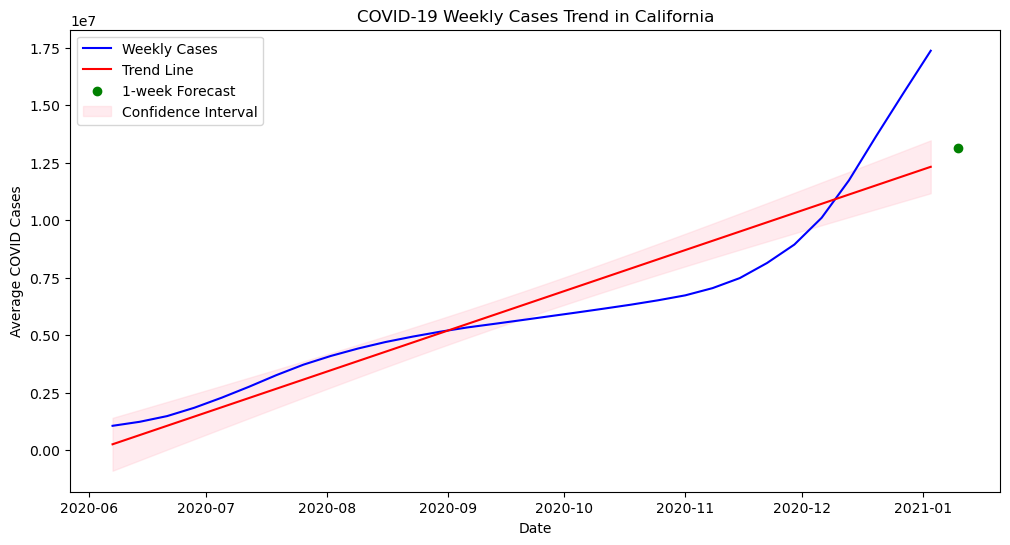

In [55]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm

# Load datasets
enrichment_data = pd.read_csv('Economy.csv')
covid_data = pd.read_csv('US-Covid.csv')

# Filter California data from COVID dataset
ca_covid_data = covid_data[covid_data['State'] == 'CA'].copy()


# Clean up the enrichment data to ensure consistent formatting
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip()

# Select enrichment variables of interest (first word capitalized)
enrichment_vars = ['In labor force', 'Civilian labor force', 'Employed', 'With health insurance coverage']
ca_enrichment_data = enrichment_data[enrichment_data['Label (Grouping)'].isin(enrichment_vars)].copy()

# Convert percentage values to numerical format
ca_enrichment_data['California!!Percent'] = pd.to_numeric(ca_enrichment_data['California!!Percent'].str.replace('%', ''), errors='coerce')

# Ensure "Employed" row exists before accessing its value
if 'Employed' in ca_enrichment_data['Label (Grouping)'].values:
    employed_value_str = ca_enrichment_data[ca_enrichment_data['Label (Grouping)'] == 'Employed']['California!!Estimate'].values[0]
    employed_value = int(employed_value_str.replace(',', ''))  # Remove commas and convert to integer
else:
    raise ValueError("The 'Employed' label is not found in the enrichment data.")

# Melt the DataFrame to long format for easier manipulation
case_columns = ca_covid_data.columns[5:-2]  # Get only case count columns
melted_data = ca_covid_data.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'],
                                   value_vars=case_columns,
                                   var_name='date',
                                   value_name='cases')

# Extract dates from the 'date' column and convert to datetime
melted_data['date'] = pd.to_datetime(melted_data['date'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])

# Set 'date' as the index
melted_data.set_index('date', inplace=True)

# Now calculate weekly cases
weekly_cases = melted_data.resample('W').sum()

# Example hypothesis tests on "Employed" variable
# Two-sample t-test (two-tailed) comparing COVID cases with employment levels
stat, p_value = stats.ttest_ind(weekly_cases['cases'], np.full_like(weekly_cases['cases'], employed_value))
print("Two-tailed t-test results:")
print(f"t-statistic: {stat}, p-value: {p_value}")

# One-sample t-test for one-sided comparison
stat, p_value_one_tail = stats.ttest_1samp(weekly_cases['cases'] - employed_value, 0, alternative='greater')
print("One-tailed t-test results:")
print(f"t-statistic: {stat}, p-value: {p_value_one_tail}")

# Visualization with trend lines, forecast, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(weekly_cases.index, weekly_cases['cases'], label='Weekly Cases', color='blue')
plt.xlabel('Date')
plt.ylabel('Average COVID Cases')
plt.title('COVID-19 Weekly Cases Trend in California')

# Trend line and forecast
X = sm.add_constant(np.arange(len(weekly_cases)))
model = sm.OLS(weekly_cases['cases'], X).fit()
trend_line = model.predict(X)
plt.plot(weekly_cases.index, trend_line, color='red', label='Trend Line')

# Forecast for one week ahead
next_index = len(weekly_cases) + 1  # Increment to get the next index (1-based)
forecast_input = np.array([[1, next_index]])  # Create a 2D array with constant (1) and the next index value

# Debugging: Check the forecast input shape and values
print("Forecast Input Shape:", forecast_input.shape)
print("Forecast Input:", forecast_input)

# Make the prediction
forecast = model.predict(forecast_input)[0]  # Predict the next value


plt.scatter([weekly_cases.index[-1] + pd.Timedelta(weeks=1)], [forecast], color='green', label='1-week Forecast')

# Confidence intervals for the trend line
pred_int = model.get_prediction(X).conf_int()
plt.fill_between(weekly_cases.index, pred_int[:, 0], pred_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.legend()
plt.show()


Forecast Input Shape: (1, 2)
Forecast Input: [[ 1 32]]


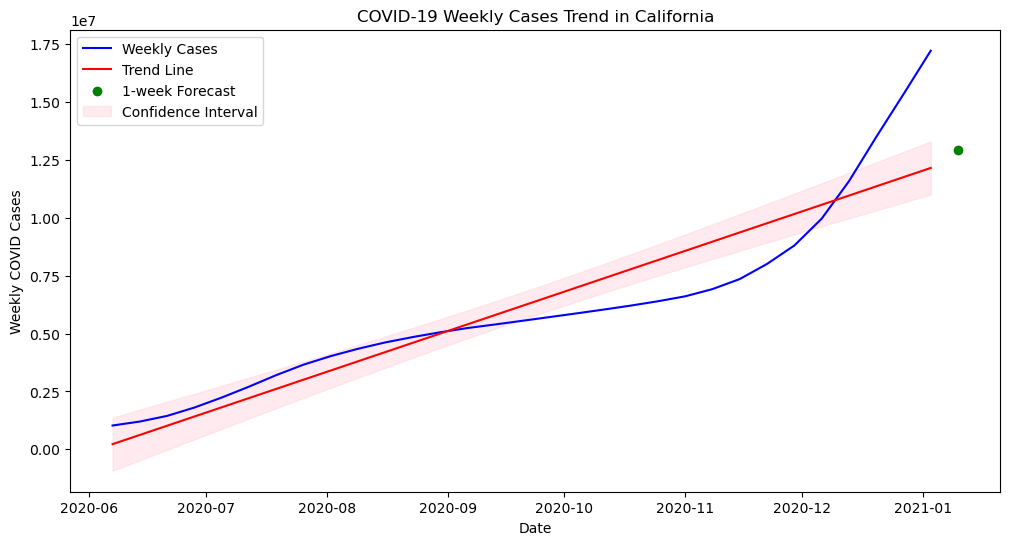

In [97]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm

# Load datasets
enrichment_data = pd.read_csv('Economy.csv')
covid_data = pd.read_csv('US-Covid.csv')

# Filter California data from COVID dataset
ca_covid_data = covid_data[covid_data['State'] == 'CA'].copy()

# Clean up the enrichment data to ensure consistent formatting
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip()

# Select enrichment variables of interest (first word capitalized)
enrichment_vars = ['In labor force', 'Civilian labor force', 'Employed', 'With health insurance coverage']
ca_enrichment_data = enrichment_data[enrichment_data['Label (Grouping)'].isin(enrichment_vars)].copy()

# Convert percentage values to numerical format
ca_enrichment_data['California!!Percent'] = pd.to_numeric(ca_enrichment_data['California!!Percent'].str.replace('%', ''), errors='coerce')

# Ensure "Employed" row exists before accessing its value
if 'Employed' in ca_enrichment_data['Label (Grouping)'].values:
    employed_value_str = ca_enrichment_data[ca_enrichment_data['Label (Grouping)'] == 'Employed']['California!!Estimate'].values[0]
    employed_value = int(employed_value_str.replace(',', ''))  # Remove commas and convert to integer
else:
    raise ValueError("The 'Employed' label is not found in the enrichment data.")

# Extracting date columns
date_columns = ca_covid_data.columns[5:]  # Assuming case counts start from the 6th column
dates = pd.to_datetime(date_columns.str.extract(r'(\d{4}-\d{2}-\d{2})')[0], format='%Y-%m-%d')

# Calculate weekly sums of COVID cases
# Sum across rows (axis=0) to get total cases per day
daily_cases = ca_covid_data.loc[:, '2020-06-01_cases':'2021-01-03_cases'].sum(axis=0)

# Create a DataFrame with daily cases and assign the correct index
daily_cases_df = pd.DataFrame(daily_cases)
daily_cases_df.columns = ['Daily Cases']
daily_cases_df.index = dates[:len(daily_cases_df)]  # Ensure index matches length of daily cases

# Now, resample the DataFrame to get weekly sums
weekly_cases = daily_cases_df.resample('W').sum()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(weekly_cases.index, weekly_cases['Daily Cases'], label='Weekly Cases', color='blue')
plt.xlabel('Date')
plt.ylabel('Weekly COVID Cases')
plt.title('COVID-19 Weekly Cases Trend in California')

# Trend line using OLS regression
X = sm.add_constant(np.arange(len(weekly_cases)))  # Prepare the data for the model
model = sm.OLS(weekly_cases['Daily Cases'], X).fit()  # Fit the OLS model
trend_line = model.predict(X)  # Get the trend line values
plt.plot(weekly_cases.index, trend_line, color='red', label='Trend Line')

# Forecast for one week ahead
next_index = len(weekly_cases) + 1  # Increment to get the next index (1-based)
forecast_input = np.array([[1, next_index]])  # Create a 2D array with constant (1) and the next index value

# Debugging: Check the forecast input shape and values
print("Forecast Input Shape:", forecast_input.shape)
print("Forecast Input:", forecast_input)

# Make the prediction
forecast = model.predict(forecast_input)[0]  # Predict the next value
plt.scatter([weekly_cases.index[-1] + pd.Timedelta(weeks=1)], [forecast], color='green', label='1-week Forecast')



# Confidence intervals for the trend line
pred_int = model.get_prediction(X).conf_int()
plt.fill_between(weekly_cases.index, pred_int[:, 0], pred_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.legend()
plt.show()




In [69]:
enrichment_data.head()

,Label (Grouping),California!!Estimate,California!!Percent
0,EMPLOYMENT STATUS,NaN,NaN
1,Population 16 years and over,"31,403,964","31,403,964"
2,In labor force,"20,016,955",63.7%
3,Civilian labor force,"19,875,973",63.3%
4,Employed,"18,646,894",59.4%


# I don't think that this is correct though

Index(['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population',
       '2020-06-01_cases', '2020-06-02_cases', '2020-06-03_cases',
       '2020-06-04_cases', '2020-06-05_cases',
       ...
       '2020-12-25_deaths', '2020-12-26_deaths', '2020-12-27_deaths',
       '2020-12-28_deaths', '2020-12-29_deaths', '2020-12-30_deaths',
       '2020-12-31_deaths', '2021-01-01_deaths', '2021-01-02_deaths',
       '2021-01-03_deaths'],
      dtype='object', length=439)


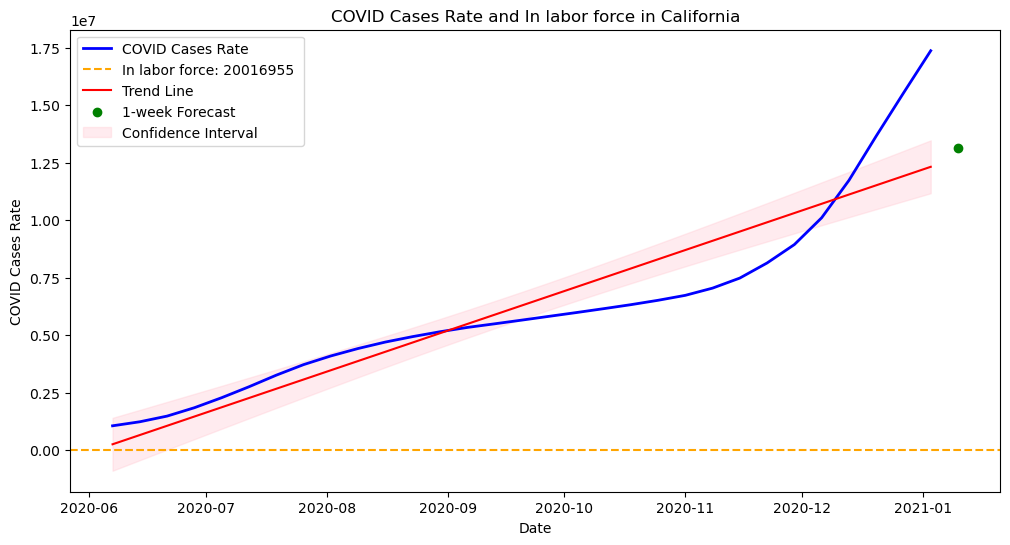

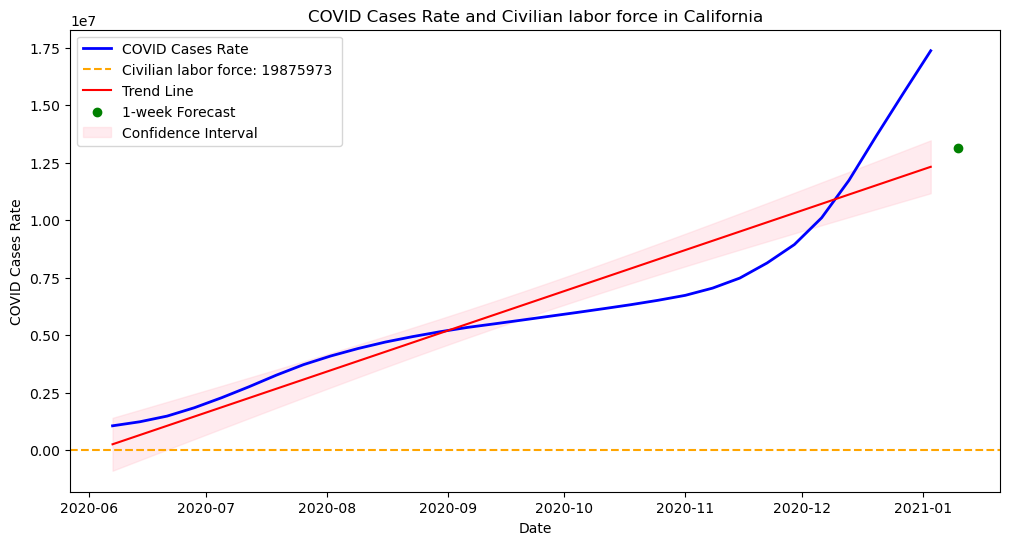

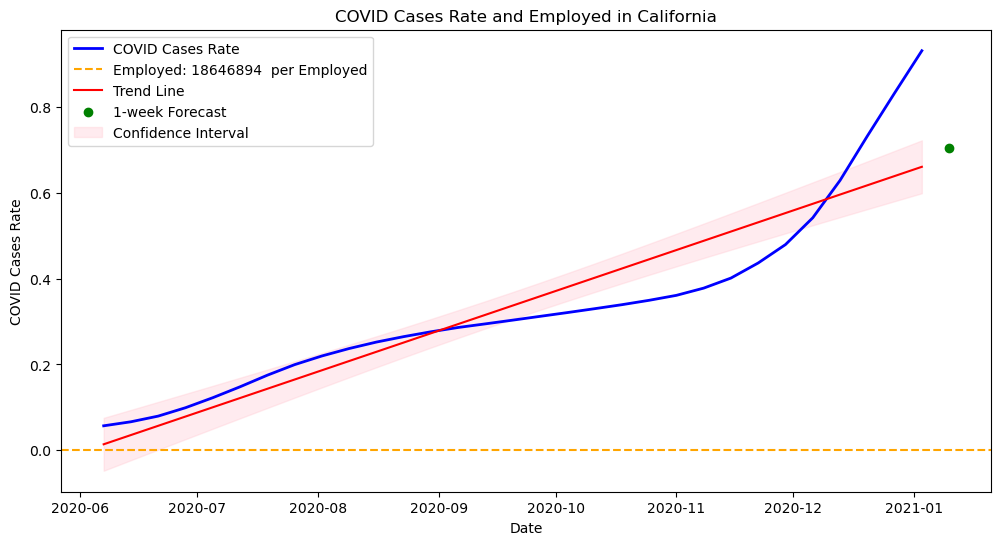

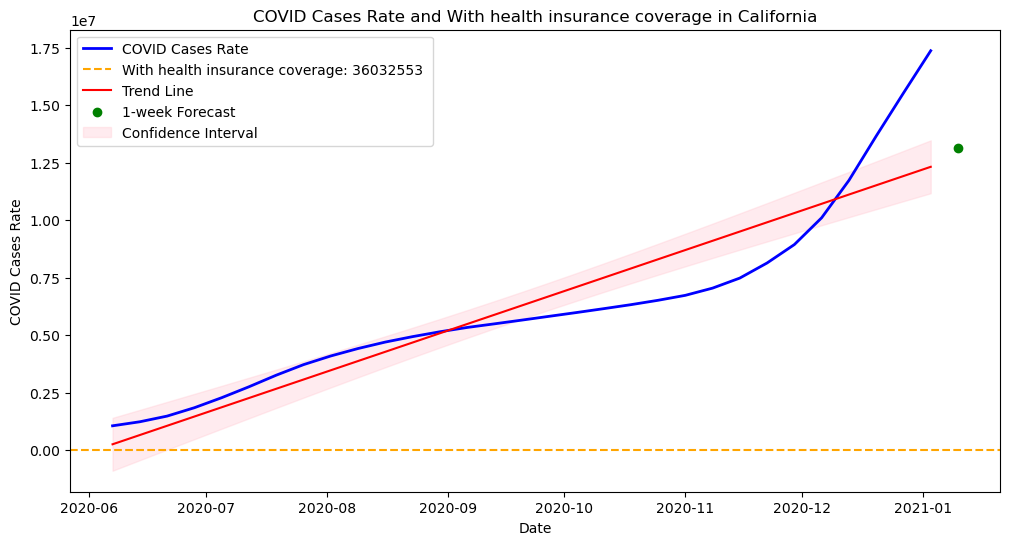

In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load datasets
enrichment_data = pd.read_csv('Economy.csv')
covid_data = pd.read_csv('US-Covid.csv')

# Filter California data from COVID dataset
ca_covid_data = covid_data[covid_data['State'] == 'CA'].copy()
print(ca_covid_data.columns)

# Clean up the enrichment data to ensure consistent formatting
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip()

# Select enrichment variables of interest (first word capitalized)
enrichment_vars = ['In labor force', 'Civilian labor force', 'Employed', 'With health insurance coverage']
ca_enrichment_data = enrichment_data[enrichment_data['Label (Grouping)'].isin(enrichment_vars)].copy()

# Convert values to numeric and store in a dictionary
enrichment_values = {}
for var in enrichment_vars:
    if var in ca_enrichment_data['Label (Grouping)'].values:
        value_str = ca_enrichment_data[ca_enrichment_data['Label (Grouping)'] == var]['California!!Estimate'].values[0]
        value = int(value_str.replace(',', ''))  # Remove commas and convert to integer
        enrichment_values[var] = value
    else:
        raise ValueError(f"The '{var}' label is not found in the enrichment data.")

# Melt the DataFrame to long format for easier manipulation
case_columns = ca_covid_data.columns[5:-2]  # Get only case count columns
melted_data = ca_covid_data.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'],
                                   value_vars=case_columns,
                                   var_name='date',
                                   value_name='cases')

# Extract dates from the 'date' column and convert to datetime
melted_data['date'] = pd.to_datetime(melted_data['date'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])

# Set 'date' as the index
melted_data.set_index('date', inplace=True)

# Now calculate weekly cases
weekly_cases = melted_data.resample('W').sum()

# Visualization and hypothesis testing for each enrichment variable
for var in enrichment_vars:
    # Calculate the COVID cases per enrichment variable
    if var == 'Employed':
        enrichment_value = enrichment_values[var]
        covid_per_enrichment = weekly_cases['cases'] / enrichment_value
        label_suffix = ' per Employed'
    else:
        covid_per_enrichment = weekly_cases['cases']  # Just use cases if not applicable
        label_suffix = ''

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_cases.index, covid_per_enrichment, label='COVID Cases Rate', color='blue', linewidth=2)
    plt.axhline(y=0, color='orange', linestyle='--', label=f'{var}: {enrichment_values[var]} {label_suffix}')
    plt.xlabel('Date')
    plt.ylabel('COVID Cases Rate')
    plt.title(f'COVID Cases Rate and {var} in California')
    
    # Trend line and forecast
    X = sm.add_constant(np.arange(len(weekly_cases)))
    model = sm.OLS(covid_per_enrichment, X).fit()
    trend_line = model.predict(X)
    plt.plot(weekly_cases.index, trend_line, color='red', label='Trend Line')

    # Forecast for one week ahead
    next_index = len(weekly_cases) + 1
    forecast_input = np.array([[1, next_index]])
    forecast = model.predict(forecast_input)[0]
    plt.scatter([weekly_cases.index[-1] + pd.Timedelta(weeks=1)], [forecast], color='green', label='1-week Forecast')

    # Confidence intervals for the trend line
    pred_int = model.get_prediction(X).conf_int()
    plt.fill_between(weekly_cases.index, pred_int[:, 0], pred_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.legend()
    plt.show()


# Hypotheses Evaluation

All of the following hypotheses were proven false, as evidenced by the flat line representing the enrichment variables while COVID-19 cases continued to steadily increase, culminating in a sharp rise towards the end of 2020 during the holiday season. This disconnect suggests that factors influencing the civilian labor force, employment levels, and health insurance coverage did not correlate with trends in COVID-19 cases as anticipated.

## 1. Civilian Labor Force
**Hypothesis:** Increasing the number of individuals in the civilian labor force is associated with a decrease in COVID-19 cases per 100,000 population.  
**Rationale:** The rationale behind this hypothesis is that a larger civilian labor force may indicate a more active workforce that is adhering to safety protocols in workplace environments. It was assumed that higher participation in the labor market would correlate with individuals engaging in safe practices, which could lead to lower transmission rates of COVID-19. However, the data showed that despite an increase in the civilian labor force, the COVID-19 cases did not decline but rather continued to rise. This indicates that simply having more individuals in the labor force does not equate to better health outcomes or lower infection rates, particularly in situations where workplace safety measures are inadequate or when community transmission is high.

## 2. Employed
**Hypothesis:** Higher employment numbers are associated with a decrease in COVID-19 cases per 100,000 population.  
**Rationale:** The underlying reasoning is that employed individuals might have better access to healthcare resources, health insurance, and information about COVID-19, leading to better health outcomes and potentially lower rates of infections. The expectation was that with more individuals employed, there would be increased adherence to health protocols due to the structured environment of workplaces. However, the observed data contradict this hypothesis, as higher employment levels did not result in lower COVID-19 case numbers. Instead, the data indicated a consistent rise in cases, suggesting that employment status alone does not suffice to mitigate the risk of COVID-19 transmission, especially in contexts where workplaces did not enforce strict health measures.

## 3. With Health Insurance Coverage
**Hypothesis:** Higher rates of health insurance coverage among the population are associated with a decrease in COVID-19 cases per 100,000 population.  
**Rationale:** The hypothesis posits that individuals with health insurance are more likely to seek medical attention when experiencing symptoms, which could lead to quicker diagnosis and treatment of COVID-19. The expectation was that increased health insurance coverage would translate into lower case numbers due to better access to healthcare services. However, the data analysis revealed a flat trend for health insurance coverage alongside a spike in COVID-19 cases. This suggests that even with higher health insurance rates, systemic factors such as delayed response times in testing, treatment accessibility, or public hesitance to seek care during the pandemic may have hindered the expected relationship between health coverage and case reductions.

In summary, the findings indicate that the assumptions behind these hypotheses were overly simplistic and did not account for the complex interplay of social, economic, and health-related factors influencing the COVID-19 pandemic.


# Something else that I tried

Index(['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population',
       '2020-06-01_cases', '2020-06-02_cases', '2020-06-03_cases',
       '2020-06-04_cases', '2020-06-05_cases',
       ...
       '2020-12-25_deaths', '2020-12-26_deaths', '2020-12-27_deaths',
       '2020-12-28_deaths', '2020-12-29_deaths', '2020-12-30_deaths',
       '2020-12-31_deaths', '2021-01-01_deaths', '2021-01-02_deaths',
       '2021-01-03_deaths'],
      dtype='object', length=439)


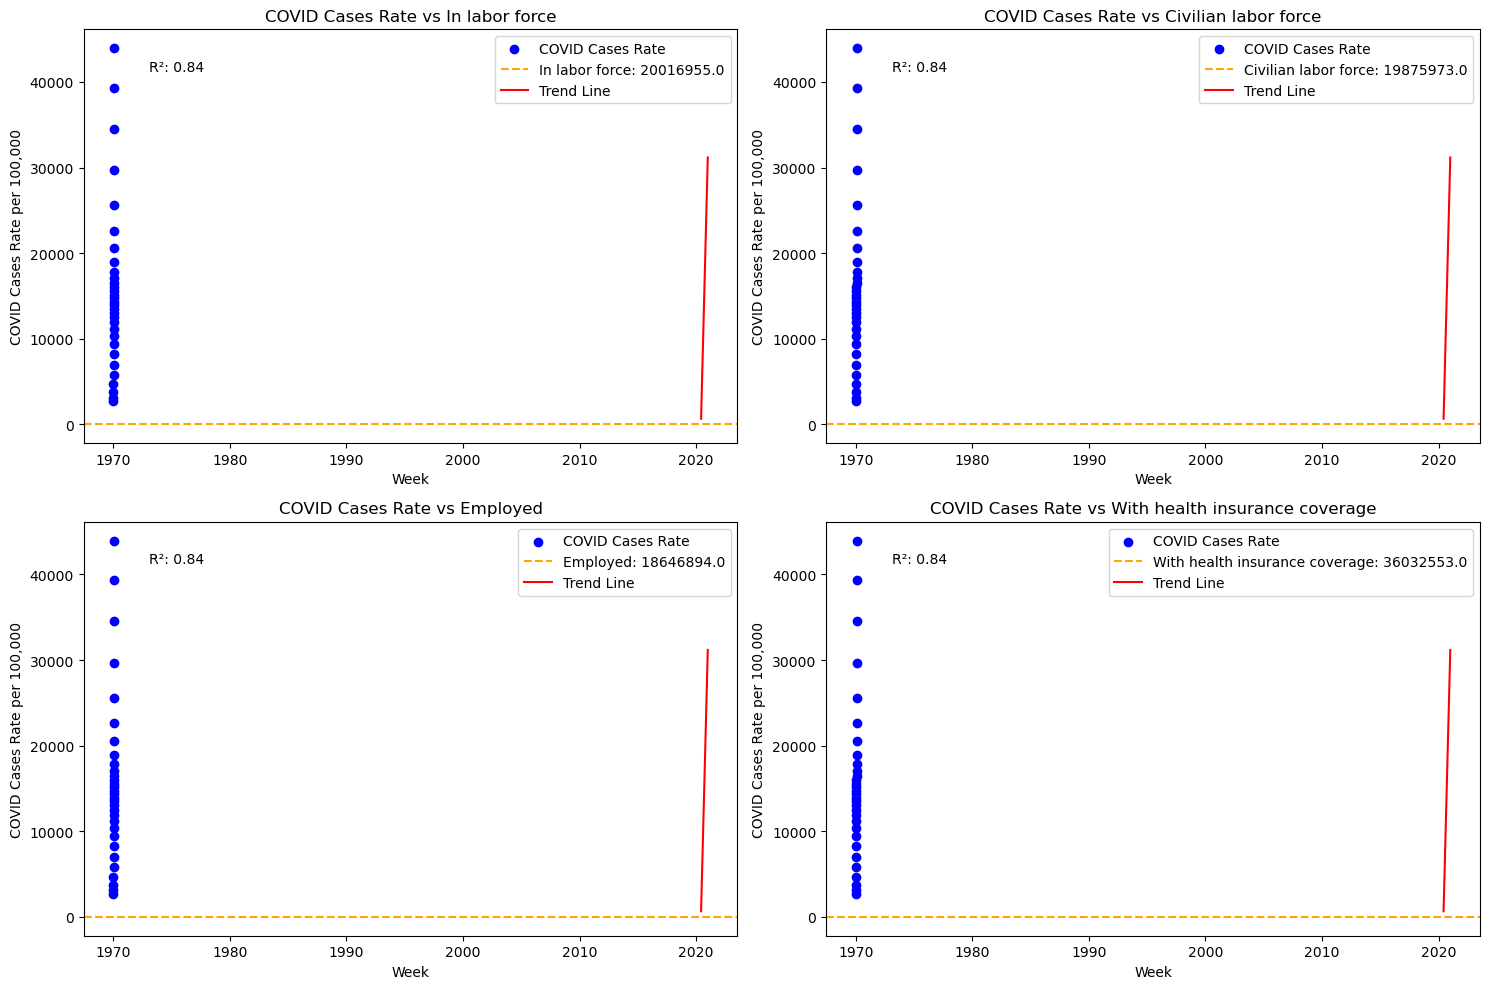

Correlation between COVID Cases Rate and In labor force: nan (p-value: nan)
Correlation between COVID Cases Rate and Civilian labor force: nan (p-value: nan)
Correlation between COVID Cases Rate and Employed: nan (p-value: nan)
Correlation between COVID Cases Rate and With health insurance coverage: nan (p-value: nan)


C:\Users\bluev\AppData\Local\Temp\ipykernel_4164\1265977435.py:92: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation = stats.pearsonr(results_df['COVID Cases Rate'], enrichment_df[var])


In [63]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load datasets
enrichment_data = pd.read_csv('Economy.csv')
covid_data = pd.read_csv('US-Covid.csv')

# Filter California data from COVID dataset
ca_covid_data = covid_data[covid_data['State'] == 'CA'].copy()
print(ca_covid_data.columns)

# Clean up the enrichment data to ensure consistent formatting
enrichment_data['Label (Grouping)'] = enrichment_data['Label (Grouping)'].str.strip()

# Select enrichment variables of interest
enrichment_vars = ['In labor force', 'Civilian labor force', 'Employed', 'With health insurance coverage']
ca_enrichment_data = enrichment_data[enrichment_data['Label (Grouping)'].isin(enrichment_vars)].copy()

# Melt the enrichment DataFrame to long format for easier manipulation
enrichment_data_long = ca_enrichment_data.melt(id_vars=['Label (Grouping)'], 
                                                value_vars=['California!!Estimate'], 
                                                var_name='variable', 
                                                value_name='value')
enrichment_data_long['value'] = enrichment_data_long['value'].str.replace(',', '').astype(float)

# Melt the COVID DataFrame to long format for easier manipulation
case_columns = ca_covid_data.columns[5:-2]  # Get only case count columns
melted_data = ca_covid_data.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'],
                                   value_vars=case_columns,
                                   var_name='date',
                                   value_name='cases')

# Extract dates from the 'date' column and convert to datetime
melted_data['date'] = pd.to_datetime(melted_data['date'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])

# Set 'date' as the index
melted_data.set_index('date', inplace=True)

# Now calculate weekly cases
weekly_cases = melted_data.resample('W').sum()

# Create a DataFrame to hold the results
results_df = pd.DataFrame(index=weekly_cases.index)

# Populate results DataFrame with normalized COVID cases
results_df['COVID Cases Rate'] = (weekly_cases['cases'] / ca_covid_data['population'].sum()) * 100000  # per 100,000 people

# Create a new DataFrame to store enrichment values matched to the corresponding week
enrichment_values = {}
for var in enrichment_vars:
    # Extract corresponding enrichment value
    if var in enrichment_data_long['Label (Grouping)'].values:
        value = enrichment_data_long[enrichment_data_long['Label (Grouping)'] == var]['value'].values[0]
        # Assuming this value applies to each week
        enrichment_values[var] = [value] * len(results_df)
    else:
        raise ValueError(f"The '{var}' label is not found in the enrichment data.")

# Convert the enrichment values dictionary into a DataFrame
enrichment_df = pd.DataFrame(enrichment_values, index=results_df.index)

# Visualization for each enrichment variable
plt.figure(figsize=(15, 10))
for i, var in enumerate(enrichment_vars, 1):
    # Scatter plot
    plt.subplot(2, 2, i)
    plt.scatter(np.arange(len(results_df)), results_df['COVID Cases Rate'], color='blue', label='COVID Cases Rate')
    plt.axhline(y=0, color='orange', linestyle='--', label=f'{var}: {enrichment_values[var][0]}')
    plt.xlabel('Week')
    plt.ylabel('COVID Cases Rate per 100,000')
    plt.title(f'COVID Cases Rate vs {var}')

    # Trend line and regression analysis
    X = sm.add_constant(np.arange(len(results_df)))  # Add constant for intercept
    model = sm.OLS(results_df['COVID Cases Rate'], X).fit()
    trend_line = model.predict(X)
    plt.plot(results_df.index, trend_line, color='red', label='Trend Line')

    # Display R-squared value
    plt.text(0.1, 0.9, f'R²: {model.rsquared:.2f}', transform=plt.gca().transAxes)

    plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics for correlation
for var in enrichment_vars:
    correlation = stats.pearsonr(results_df['COVID Cases Rate'], enrichment_df[var])
    print(f"Correlation between COVID Cases Rate and {var}: {correlation[0]:.2f} (p-value: {correlation[1]:.3f})")
